# DSL - Audio Speech Analysis for Age Estimation through Machine Learning Regression

Main notebook of the project, here we perform Exploratory Data Analysis on the data provided apriori, and on the features that we independently extracted from the audio files, following a stage where we study the density of the outliers in a univariate and multivariate settings exploiting statistics, graphs and clustering techniques. In this step we arrange a first transformation pipeline for our data, and we study how the choice of different scaling techniques affects the distribution of the data and the presence of the outliers previously identified.

- - -  

## Updated Index

1. **Import Dependencies**  
   - Key libraries for data manipulation, visualization, and machine learning.

2. **Data Loading**  
   - Loading the *Vanilla* dataset.  
   - Loading the *Extracted Features* dataset.

3. **Data Overview**  
   - **3.1. Quick Look & Basic Statistics**  
     - Data shapes, columns, and dtypes.  
     - Summary statistics (mean, std, min, max).  
     - Missing values check, data cleaning notes.  
   - **3.2. Exploratory Data Analysis (EDA)**  
     - **3.2.1. Univariate Analysis**  
       - Histograms, kernel density plots (KDE), boxplots, violin plots.  
       - Initial detection and discussion of potential outliers.  
     - **3.2.2. Multivariate Analysis**  
       - Pair plots, correlation matrices, and scatter plots.  
       - Initial insights on relationships among features.

4. **Outlier Detection**  
   - **4.1. Univariate Outlier Detection**  
     - IQR-based approach (boxplot method).  
     - Z-score (standard deviation from the mean) approach.  
   - **4.2. Multivariate Outlier Detection**  
     - Clustering-based methods (e.g., K-means, DBSCAN).  
     - Dimensionality reduction (PCA) for visualizing outliers.  
     - Isolation Forest or other advanced methods.  
   - **4.3. Outlier Handling**  
     - Potential removal, capping, or transformation.  
     - Explanation for chosen handling strategy.

5. **Data Transformation & Feature Scaling**  
   - **5.1. Comparison of Different Scaling Techniques**  
     - StandardScaler (z-score).  
     - MinMaxScaler (normalizing to [0,1]).  
     - RobustScaler (less sensitive to outliers).  
   - **5.2. Impact on Outlier Detection**  
     - Re-check univariate outliers (boxplots, stats) after scaling.  
     - Re-run clustering (DBSCAN or other methods) to see changes.  
   - **5.3. Final Transformation Pipeline**  
     - Justify choice of scaler and outlier handling method.  
     - Document any additional feature engineering steps if necessary.

## Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import librosa 

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import seaborn as sns

from scipy.stats import gaussian_kde

from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBPipeline


from catboost import CatBoostRegressor

from prettytable import PrettyTable
import itertools

import warnings
warnings.filterwarnings('ignore')

## Data Loading

### Vanilla Datasets (Development & Evaluation)

In [2]:
# data paths
DEV_DATA_PATH = "data/development.csv"   
EVAL_DATA_PATH = "data/evaluation.csv"  

# load datasets
df_dev = pd.read_csv(DEV_DATA_PATH, index_col='Id') 
df_eval = pd.read_csv(EVAL_DATA_PATH, index_col='Id')

# simple transformations inferred from first exploration of the data
def preprocess_and_transform_columns(df):
    df = df.rename(columns={"age": "target"})  # Rename 'age' to 'target'
    df = df.drop(columns=["sampling_rate", "path"])  # Remove unnecessary columns
    df["tempo"] = df["tempo"].apply(lambda x: float(x[1:-1]))  # Transform 'tempo' values from 'str' to 'float'
    df["gender"] = df["gender"].replace("famale", "female") # Single typo in evaluation dataset
    return df

df_dev = preprocess_and_transform_columns(df_dev)
df_eval = preprocess_and_transform_columns(df_eval)

df_dev_copy = df_dev.copy()
df_eval_copy = df_eval.copy()

## Extracted Features Datasets (Development & Evaluation)

- **Fundamental Frequency Dataset**  
  Statistical summary of f₀.

- **Spectral Features Dataset**  
  Statistical summary of the spectral features (the ones that, when extracted, were represented as 1-D arrays).

- **Spectral Contrast Dataset**  
  Statistical summary of the spectral contrast feature for each row of the matrix (in contrast to spectral features, this was represented as a matrix with 7 rows and *m* (variable) columns).

- **Melspectrogram Dataset**  
  Divided into different frequency bands, on which the weighted mean frequency is calculated. For each frequency band, a statistical summary is reported.

- **MFCC & Deltas Dataset**  
  Selected the first 13 most informative rows, and for each of them, a statistical summary is reported.

In [7]:
# development set
df_dev_fundamental_freq = pd.read_csv("data/dev_fundamental_frequency_audio_features.csv")
df_dev_spectral_features = pd.read_csv("data/dev_spectral_audio_features.csv")
df_dev_spectral_contrast = pd.read_csv("data/dev_spectral_contrast_audio_features.csv")
df_dev_melspectrogram = pd.read_csv("data/dev_melspectrogram_audio_features.csv")
df_dev_mfcc_and_deltas = pd.read_csv("data/dev_mfcc_deltas_audio_features.csv")

# evaluation set
df_eval_fundamental_freq = pd.read_csv("data/eval_fundamental_frequency_audio_features.csv")
df_eval_spectral_features = pd.read_csv("data/eval_spectral_audio_features.csv")
df_eval_spectral_contrast = pd.read_csv("data/eval_spectral_contrast_audio_features.csv")
df_eval_melspectrogram = pd.read_csv("data/eval_melspectrogram_audio_features.csv")
df_eval_mfcc_and_deltas = pd.read_csv("data/dev_mfcc_deltas_audio_features.csv")

In [6]:
print(df_dev_copy.info())  # summary of the DataFrame
display(df_dev_copy.head())  # first few rows of the DataFrame

<class 'pandas.core.frame.DataFrame'>
Index: 2933 entries, 0 to 2932
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   target                  2933 non-null   float64
 1   gender                  2933 non-null   object 
 2   ethnicity               2933 non-null   object 
 3   mean_pitch              2933 non-null   float64
 4   max_pitch               2933 non-null   float64
 5   min_pitch               2933 non-null   float64
 6   jitter                  2933 non-null   float64
 7   shimmer                 2933 non-null   float64
 8   energy                  2933 non-null   float64
 9   zcr_mean                2933 non-null   float64
 10  spectral_centroid_mean  2933 non-null   float64
 11  tempo                   2933 non-null   float64
 12  hnr                     2933 non-null   float64
 13  num_words               2933 non-null   int64  
 14  num_characters          2933 non-null   int64

,target,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,,
0,24.0,female,arabic,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,151.999081,-123.999726,69,281,39,23.846893
1,22.5,female,hungarian,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,129.199219,-86.928478,69,281,21,19.388662
2,22.0,female,portuguese,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,117.453835,-98.450670,69,281,1,21.640998
3,22.0,female,english,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,117.453835,-56.459762,69,281,9,19.644127
4,22.0,male,dutch,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,112.347147,-80.349204,69,281,11,18.041905


In [7]:
print(df_eval_copy.info())
display(df_eval_copy.head())

<class 'pandas.core.frame.DataFrame'>
Index: 691 entries, 0 to 690
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  691 non-null    object 
 1   ethnicity               691 non-null    object 
 2   mean_pitch              691 non-null    float64
 3   max_pitch               691 non-null    float64
 4   min_pitch               691 non-null    float64
 5   jitter                  691 non-null    float64
 6   shimmer                 691 non-null    float64
 7   energy                  691 non-null    float64
 8   zcr_mean                691 non-null    float64
 9   spectral_centroid_mean  691 non-null    float64
 10  tempo                   691 non-null    float64
 11  hnr                     691 non-null    float64
 12  num_words               691 non-null    int64  
 13  num_characters          691 non-null    int64  
 14  num_pauses              691 non-null    int64  

,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,
0,male,spanish,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,80.749512,-116.662338,69,281,2,38.198503
1,male,xiang,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,89.102909,-78.253824,69,281,27,29.605442
2,male,igbo,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,123.046875,-71.630742,6,22,2,2.275556
3,female,spanish,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,123.046875,-101.533013,69,281,31,22.151837
4,male,spanish,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,112.347147,-134.914070,69,281,35,22.430476


## EDA

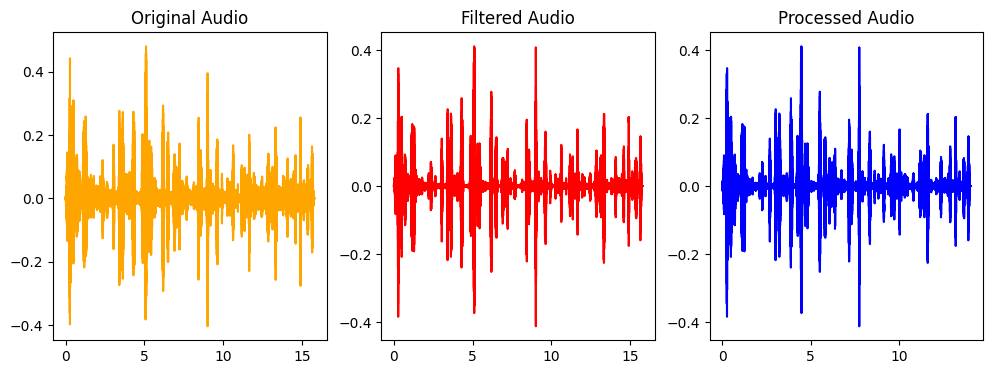

In [8]:
from utils import audio_preprocessing as ap

input_file = "data/audios_development/623.wav"
def plot_audio(y, sr=22050, c='b', s=False, ax=None, title='Audio Signal'):
    if ax == None:
        fig, ax = plt.subplots(1)
    if s:
        ax.plot(np.arange(y.size)/sr, y, c=c)
    else:
        ax.plot(y, c=c)
    ax.title.set_text(title)
    return ax

y, sr = librosa.load(input_file)
y_noise = ap.reduce_noise(y=y, sr=sr)
    
# Step 2: Apply band-pass filter
y_filter = ap.bandpass_filter(y=y_noise, sr=sr)
y_processed = ap.process_audio(y=y_filter, sr=sr)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
plot_audio(y, c='orange', s=True, ax=ax[0], title = 'Original Audio')
plot_audio(y_filter, c='red', s=True, ax=ax[1], title = 'Filtered Audio')
plot_audio(ap.process_audio(y, sr), s=True, c='b', ax=ax[2], title = 'Processed Audio')
plt.show()

In [9]:
display(df_dev_copy.describe(include="all").T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
target,2933.0,NaN,NaN,NaN,27.897886,13.093316,6.0,19.0,23.0,32.0,97.0
gender,2933,2,female,1468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ethnicity,2933,165,igbo,1081,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_pitch,2933.0,NaN,NaN,NaN,1189.536569,414.193673,346.97433,818.92236,1208.9983,1523.7777,2724.8928
max_pitch,2933.0,NaN,NaN,NaN,3779.570485,532.847869,935.51556,3948.2344,3998.3972,3999.4854,3999.7925
min_pitch,2933.0,NaN,NaN,NaN,146.93493,3.757917,145.34914,145.41914,145.62201,146.82089,202.0407
jitter,2933.0,NaN,NaN,NaN,0.02119,0.006626,0.007292,0.016734,0.020525,0.024558,0.096153
shimmer,2933.0,NaN,NaN,NaN,0.107741,0.029005,0.045205,0.087378,0.104697,0.124993,0.265167
energy,2933.0,NaN,NaN,NaN,0.005208,0.006074,0.000028,0.00196,0.003716,0.006338,0.129114
zcr_mean,2933.0,NaN,NaN,NaN,0.104774,0.051646,0.015947,0.060733,0.098964,0.139559,0.335976


In [10]:
display(df_eval_copy.describe(include="all").T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,691,2,male,393,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ethnicity,691,73,igbo,232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_pitch,691.0,NaN,NaN,NaN,1191.041077,379.826928,419.39615,865.61758,1209.6804,1487.32605,2201.411
max_pitch,691.0,NaN,NaN,NaN,3832.21458,451.201809,1151.0122,3955.64905,3998.6313,3999.52185,3999.7908
min_pitch,691.0,NaN,NaN,NaN,146.591685,3.212186,145.34923,145.401825,145.52914,146.39692,186.68895
jitter,691.0,NaN,NaN,NaN,0.02132,0.006399,0.009395,0.017184,0.02067,0.024536,0.07745
shimmer,691.0,NaN,NaN,NaN,0.110438,0.029365,0.035001,0.089501,0.106233,0.126537,0.246068
energy,691.0,NaN,NaN,NaN,0.005074,0.00543,0.000056,0.001851,0.003582,0.006147,0.048074
zcr_mean,691.0,NaN,NaN,NaN,0.105111,0.050162,0.018496,0.064549,0.098416,0.135834,0.335676
spectral_centroid_mean,691.0,NaN,NaN,NaN,2214.701841,571.250581,803.534172,1785.536118,2174.406614,2580.589333,4753.076563


## Target data

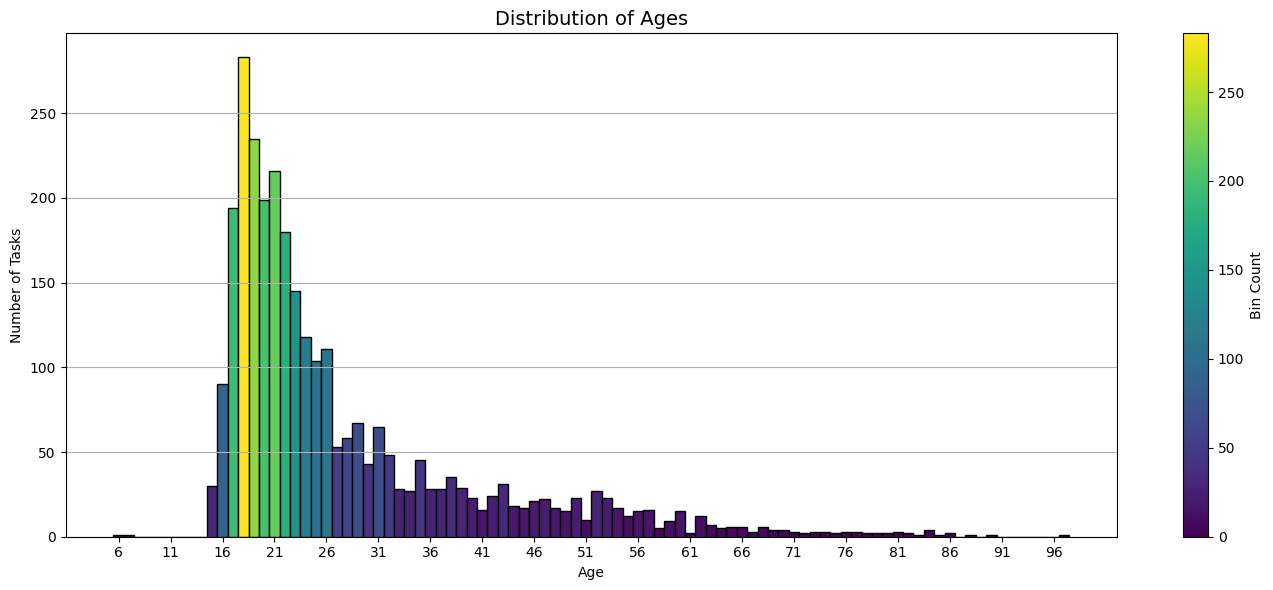

In [11]:
# collect target data
target = df_dev_copy["target"].copy()
# define bins such that each bin represents one year
bins = np.arange(target.min() - 0.5, target.max() + 1.5, 1)

fig, ax = plt.subplots(figsize=(14, 6))
N, bins, patches = ax.hist(target, bins=bins, edgecolor="black", align='mid')

# create a normalizer from bin counts
norm = mcolors.Normalize(vmin=N.min(), vmax=N.max())
cmap = cm.viridis

# color each bin patch based on its count
for count, patch in zip(N, patches):
    patch.set_facecolor(cmap(norm(count)))

ax.set_title("Distribution of Ages", fontsize=14)
ax.set_xlabel("Age")
ax.set_ylabel("Number of Tasks")
ax.set_xticks(range(int(target.min()), int(target.max()) + 1, 5))
ax.grid(axis='y')


sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([]) 
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Bin Count")

fig.tight_layout()
plt.show()


## Categorical Data

### Gender (Dev v.s. Eval)

In [12]:
dev_gender = df_dev_copy["gender"].copy()
eval_gender = df_eval_copy["gender"].copy()

dev_labels, dev_sizes = dev_gender.value_counts().index, dev_gender.value_counts().values
eval_labels, eval_sizes = eval_gender.value_counts().index, eval_gender.value_counts().values

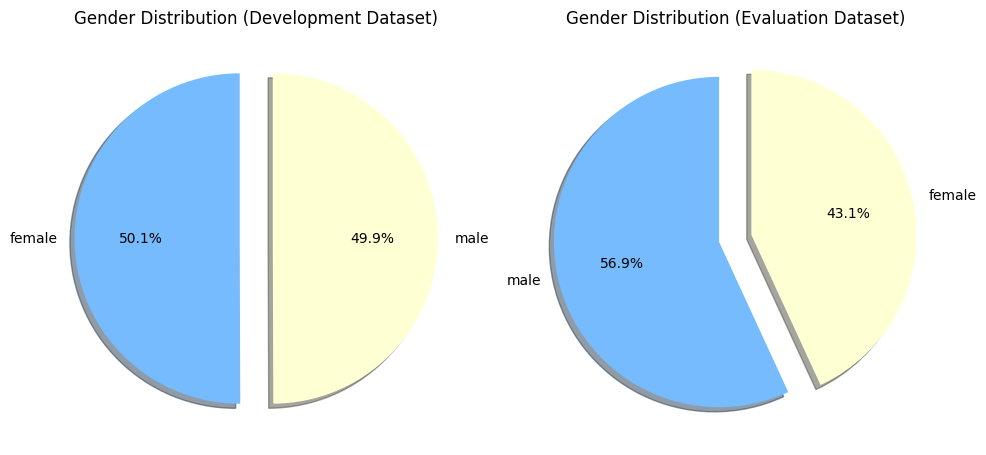

In [13]:
# define a colormap for consistent coloring
pie_colors = ["xkcd:sky blue", "xkcd:eggshell"]
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Development dataset pie chart
axes[0].pie(dev_sizes, labels=dev_labels, autopct='%1.1f%%', 
            explode=[0.1] * len(dev_labels), shadow=True, startangle=90, colors=pie_colors)
axes[0].set_title("Gender Distribution (Development Dataset)")

# Development dataset pie chart
axes[1].pie(eval_sizes, labels=eval_labels, autopct='%1.1f%%', 
            explode=[0.1] * len(eval_labels), shadow=True, startangle=90, colors=pie_colors)
axes[1].set_title("Gender Distribution (Evaluation Dataset)")

plt.tight_layout()
plt.show()

### Age Distribution Among Genders

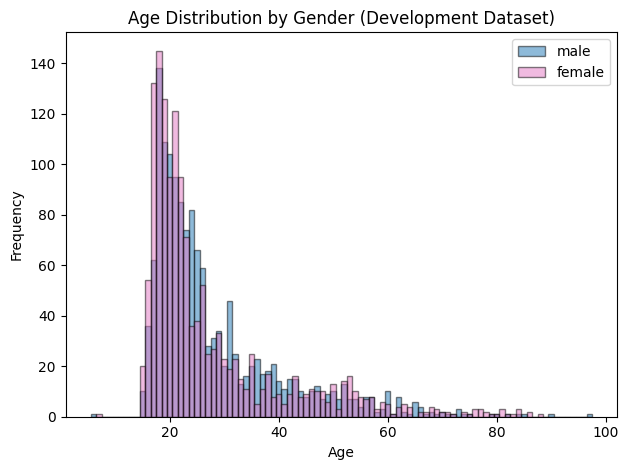

In [14]:
age_male = target[df_dev_copy["gender"] == "male"]
age_female = target[df_dev_copy["gender"] == "female"]

# bins for both distributions
bins = np.arange(min(age_male.min(), age_female.min()) - 0.5, 
                 max(age_male.max(), age_female.max()) + 1.5, 1)

plt.hist(age_male, bins=bins, edgecolor="black", align="mid", color="tab:blue", alpha=.5, label="male")
plt.hist(age_female, bins=bins, edgecolor="black", align="mid", color="tab:pink", alpha=.5, label="female")

plt.title("Age Distribution by Gender (Development Dataset)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

### Ethnicity

In [15]:
dev_ethnicity = df_dev_copy["ethnicity"]
eval_ethnicity = df_eval_copy["ethnicity"]

dev_unique_ethnicity = set(dev_ethnicity.unique())
eval_unique_ethnicity = set(eval_ethnicity.unique())

print(f"Number of different ethnicities in development dataset: {len(dev_unique_ethnicity)}")
print(f"Number of different ethnicities in evaluation dataset: {len(eval_unique_ethnicity)}")

common_ethnicities = dev_unique_ethnicity & eval_unique_ethnicity
print(f"Number of common ethnicities between development and evaluation set: {len(common_ethnicities)}")

Number of different ethnicities in development dataset: 165
Number of different ethnicities in evaluation dataset: 73
Number of common ethnicities between development and evaluation set: 17


In [16]:
print(f"{'Ethnicity':<15}{'Development Set':<20}{'Evaluation Set':<20}")
print("-" * 55)

for ethnicity in common_ethnicities:
    dev_n_instances = (df_dev_copy["ethnicity"] == ethnicity).sum()
    eval_n_instances = (df_eval_copy["ethnicity"] == ethnicity).sum()
    print(f"{ethnicity:<15}{dev_n_instances:<20}{eval_n_instances:<20}")


Ethnicity      Development Set     Evaluation Set      
-------------------------------------------------------
cameroonian    2                   1                   
annang         2                   2                   
nigerian       5                   1                   
urhobo         32                  1                   
kanuri         1                   4                   
igala          22                  4                   
ibibio         27                  2                   
afemai         2                   1                   
congolese      13                  1                   
igbo           1081                232                 
satawalese     1                   1                   
ijaw           2                   1                   
ukwani         2                   1                   
indian         2                   2                   
yoruba         12                  5                   
hausa          11                  1            

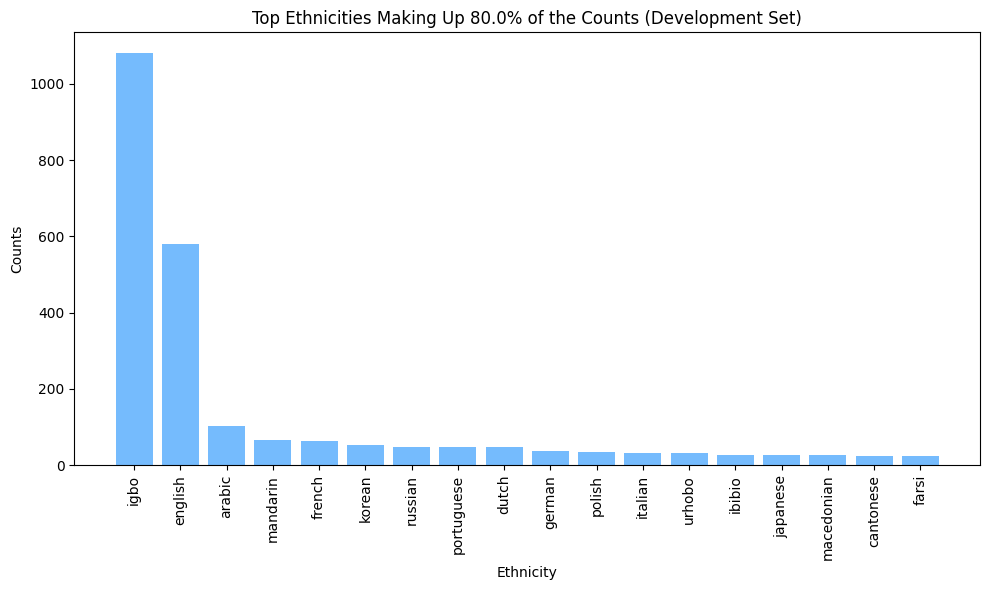

In [17]:
# Calculate counts and labels
dev_ethnicity_counts, dev_ethnicity_labels = dev_ethnicity.value_counts().values, dev_ethnicity.value_counts().index

# Compute cumulative sum and filter based on the 80% threshold
total = dev_ethnicity_counts.sum()
cumulative = dev_ethnicity_counts.cumsum()

perc = 0.80
filter_mask = cumulative <= total * perc

# Filter the counts and labels
dev_reduced_ethnicity_counts = dev_ethnicity_counts[filter_mask]
dev_reduced_ethnicity_labels = dev_ethnicity_labels[filter_mask]

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(dev_reduced_ethnicity_labels, dev_reduced_ethnicity_counts, color='xkcd:sky blue')
ax.set_xticks(range(len(dev_reduced_ethnicity_labels)))
ax.set_xticklabels(dev_reduced_ethnicity_labels, rotation=90)
ax.set_xlabel("Ethnicity")
ax.set_ylabel("Counts")
ax.set_title(f"Top Ethnicities Making Up {perc * 100}% of the Counts (Development Set)")
plt.tight_layout()
plt.show()

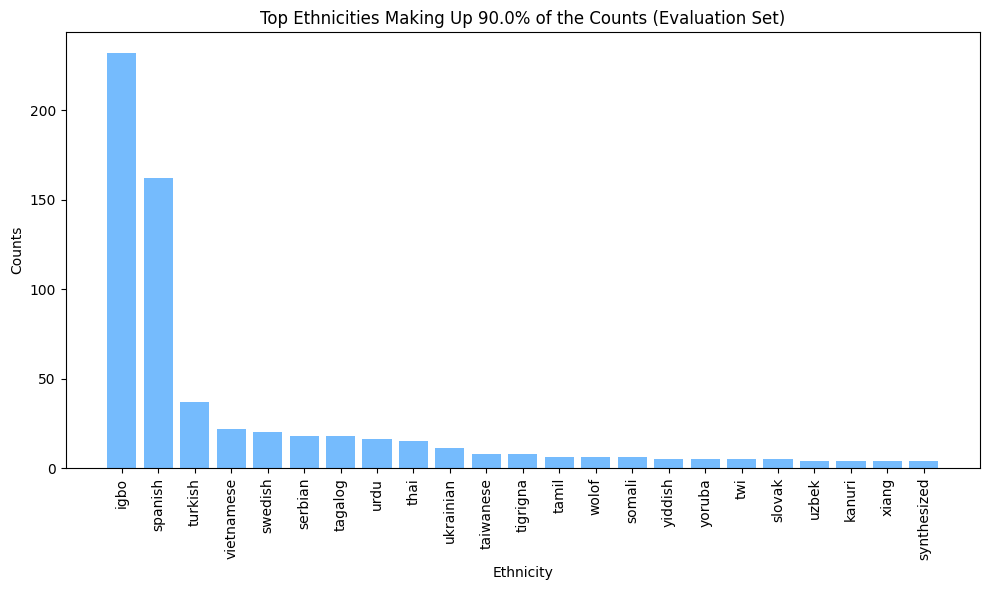

In [18]:
# Calculate counts and labels
eval_ethnicity_counts, eval_ethnicity_labels = eval_ethnicity.value_counts().values, eval_ethnicity.value_counts().index

# Compute cumulative sum and filter based on the 80% threshold
total = eval_ethnicity_counts.sum()
cumulative = eval_ethnicity_counts.cumsum()

perc = 0.9
filter_mask = cumulative <= total * perc

# Filter the counts and labels
eval_reduced_ethnicity_counts = eval_ethnicity_counts[filter_mask]
eval_reduced_ethnicity_labels = eval_ethnicity_labels[filter_mask]

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(eval_reduced_ethnicity_labels, eval_reduced_ethnicity_counts, color='xkcd:sky blue')
ax.set_xticks(range(len(eval_reduced_ethnicity_labels)))
ax.set_xticklabels(eval_reduced_ethnicity_labels, rotation=90)
ax.set_xlabel("Ethnicity")
ax.set_ylabel("Counts")
ax.set_title(f"Top Ethnicities Making Up {perc * 100}% of the Counts (Evaluation Set)")
plt.tight_layout()
plt.show()

## Numerical Data

### Provided Features

In [19]:
NUMERICAL_FEATURES = [column for column in df_dev_copy.columns if (df_dev_copy[column].dtype == "float") & (column != "target")]

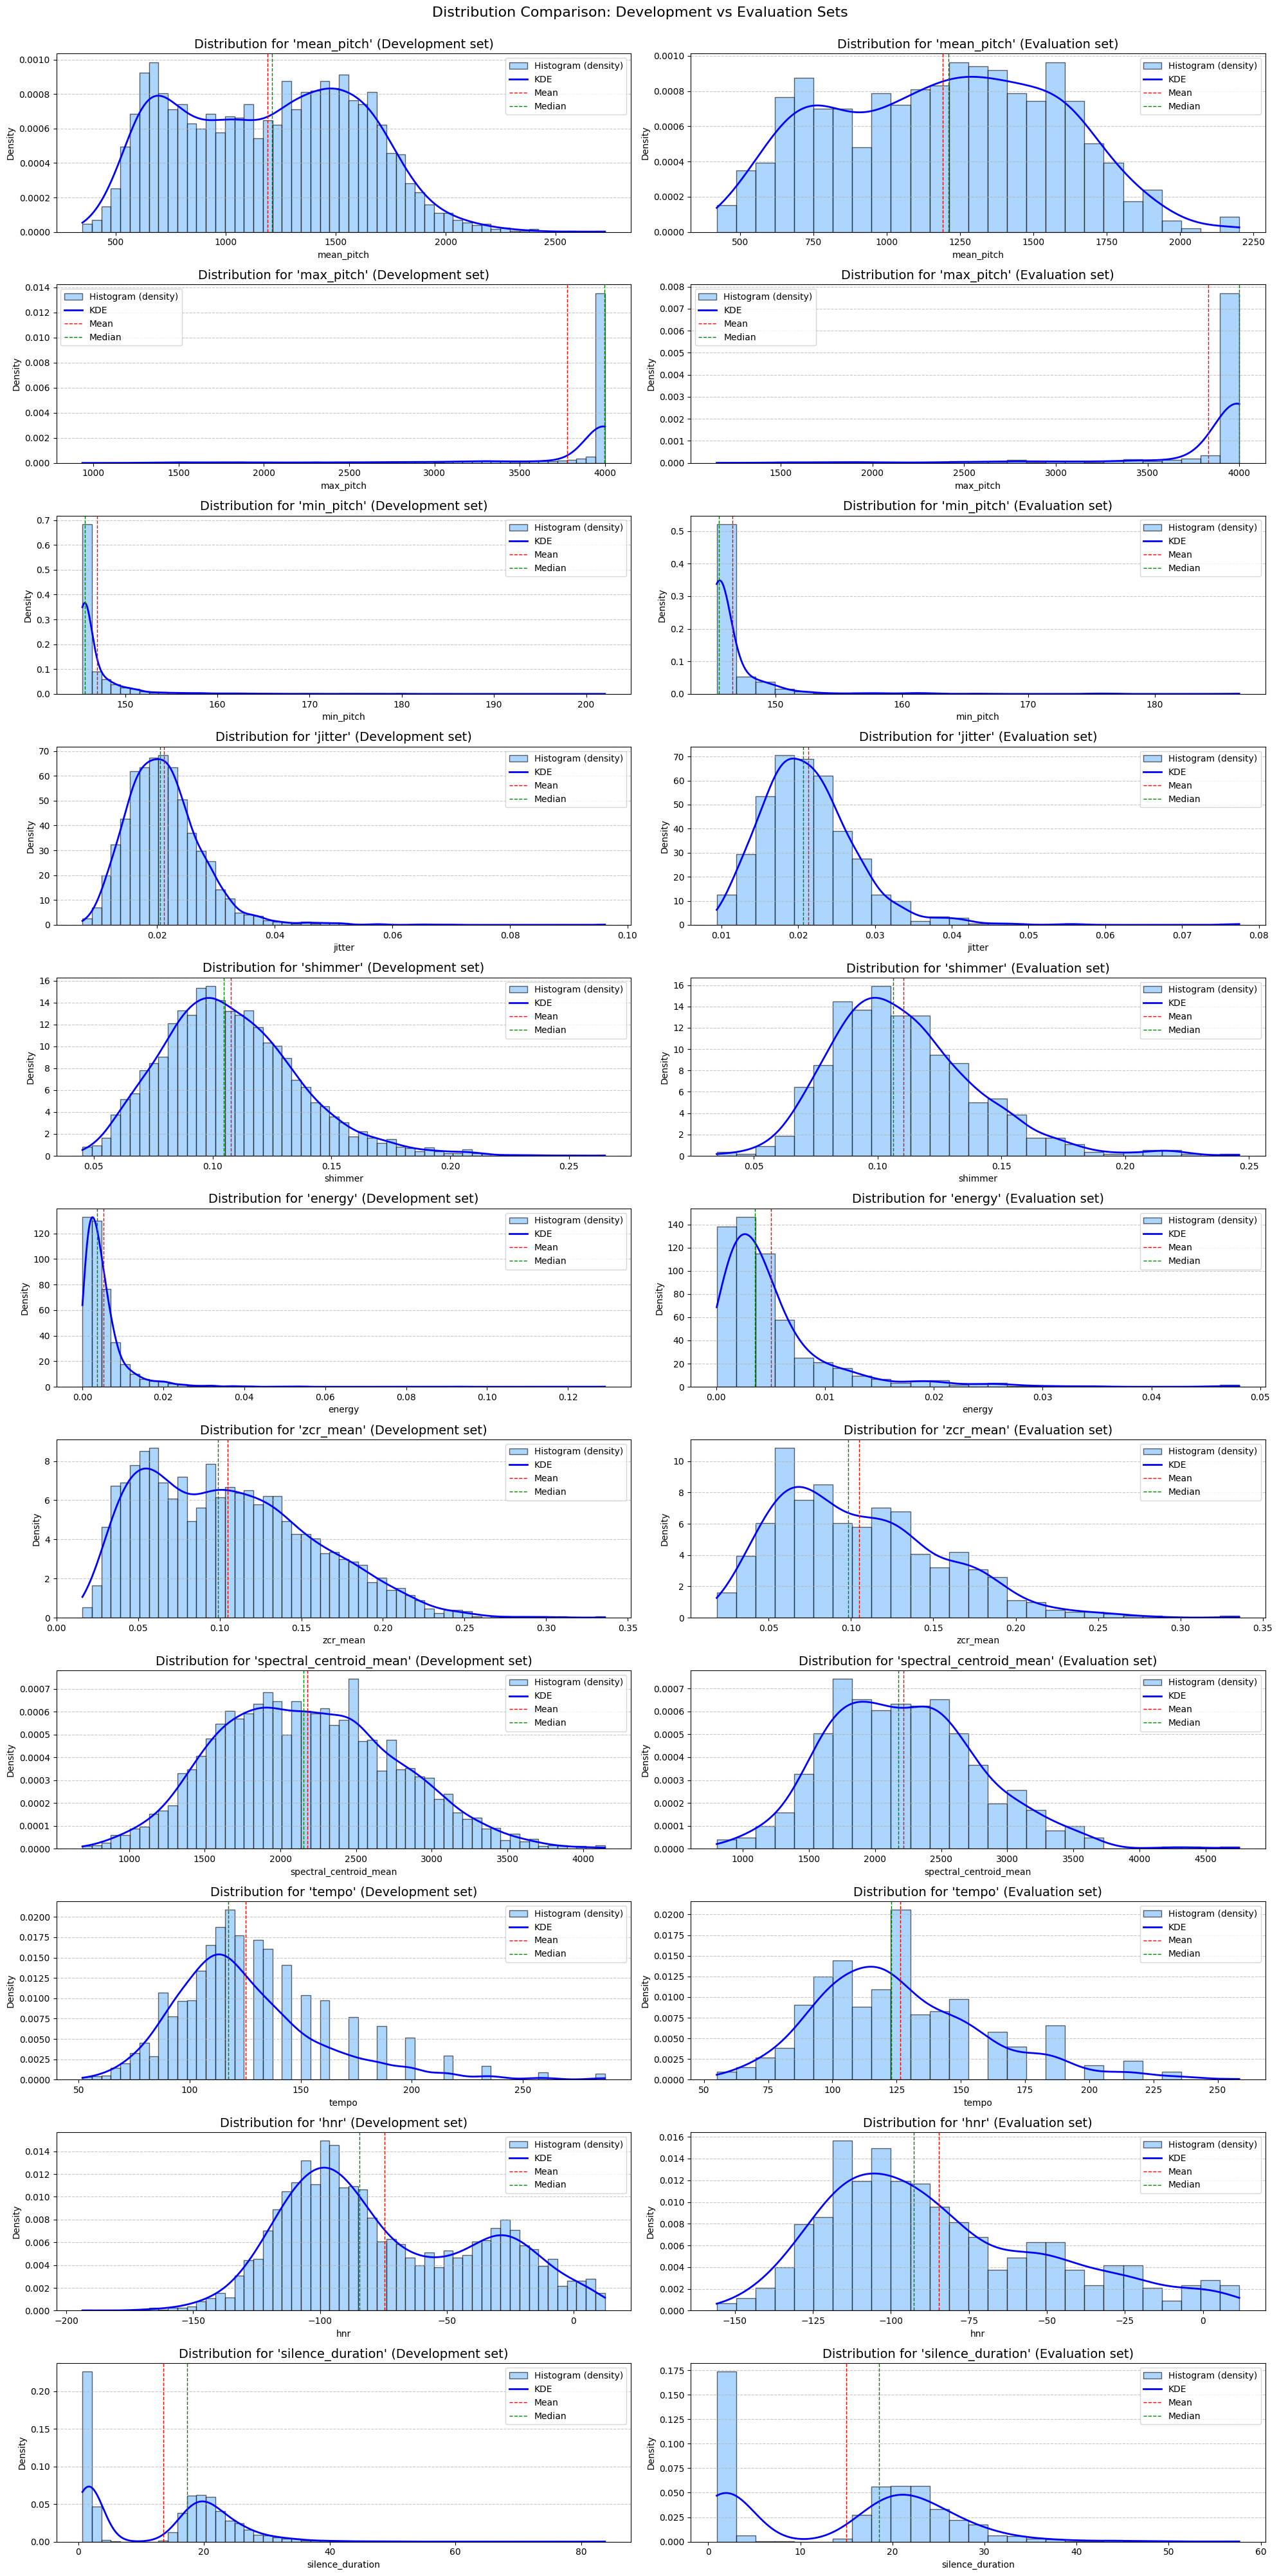

In [20]:
n_rows = len(NUMERICAL_FEATURES)

fig, axes = plt.subplots(n_rows, 2, figsize=(20, 40))

for i, feature in enumerate(NUMERICAL_FEATURES):
    # extract relative data
    dev_data = df_dev_copy[feature]
    eval_data = df_eval_copy[feature]

    # plot for dev set
    axes[i, 0].hist(dev_data, bins="sqrt", density=True, edgecolor="black", alpha=0.6, color="xkcd:sky blue", label="Histogram (density)")
    kde = gaussian_kde(dev_data)
    x_vals = np.linspace(dev_data.min(), dev_data.max(), dev_data.shape[0])
    y_vals = kde(x_vals)
    axes[i, 0].plot(x_vals, y_vals, color='blue', linewidth=2, label='KDE')

    mean_val = dev_data.mean()
    median_val = dev_data.median()
    axes[i, 0].axvline(mean_val, color='red', linestyle='--', linewidth=1, label='Mean')
    axes[i, 0].axvline(median_val, color='green', linestyle='--', linewidth=1, label='Median')

    axes[i, 0].set_title(f"Distribution for '{feature}' (Development set)", fontsize=14)
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel("Density")
    axes[i, 0].legend()
    axes[i, 0].grid(axis='y', linestyle='--', alpha=0.7)


    # plot for eval set
    axes[i, 1].hist(eval_data, bins="sqrt", density=True, edgecolor="black", alpha=0.6, color="xkcd:sky blue", label="Histogram (density)")
    kde = gaussian_kde(eval_data)
    x_vals = np.linspace(eval_data.min(), eval_data.max(), eval_data.shape[0])
    y_vals = kde(x_vals)
    axes[i, 1].plot(x_vals, y_vals, color='blue', linewidth=2, label='KDE')

    mean_val = eval_data.mean()
    median_val = eval_data.median()
    axes[i, 1].axvline(mean_val, color='red', linestyle='--', linewidth=1, label='Mean')
    axes[i, 1].axvline(median_val, color='green', linestyle='--', linewidth=1, label='Median')

    axes[i, 1].set_title(f"Distribution for '{feature}' (Evaluation set)", fontsize=14)
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].set_ylabel("Density")
    axes[i, 1].legend()
    axes[i, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Distribution Comparison: Development vs Evaluation Sets", fontsize=16, y=1)
plt.tight_layout()
plt.show()

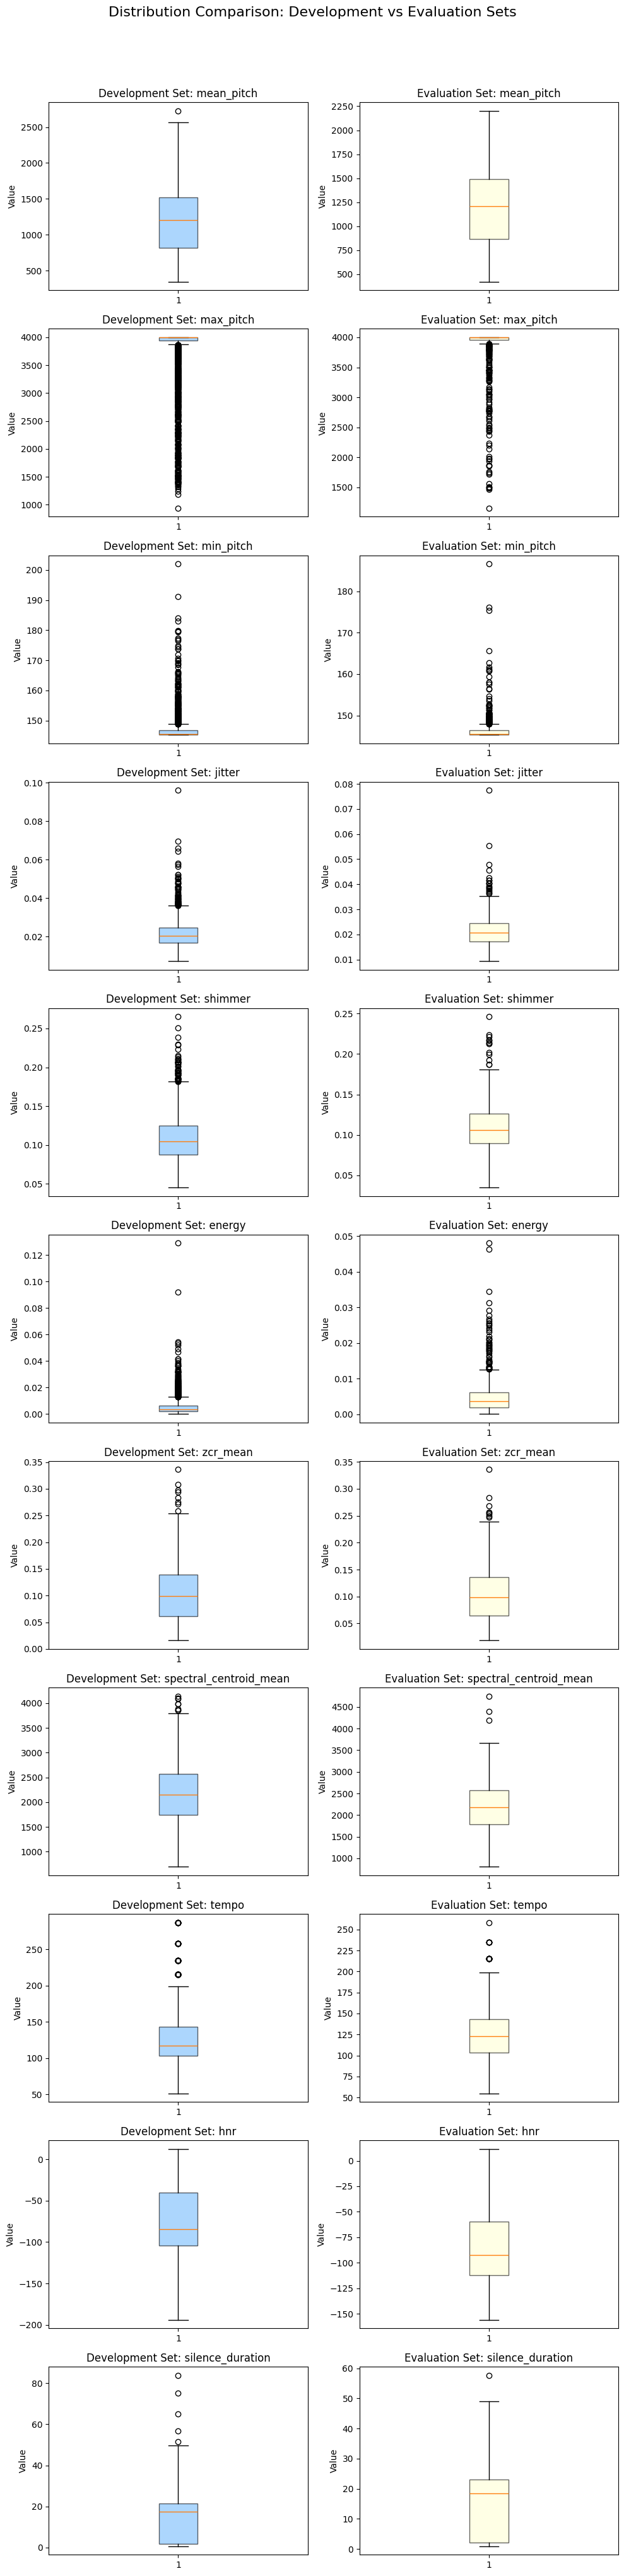

In [21]:
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 40))
plt.suptitle("Distribution Comparison: Development vs Evaluation Sets", fontsize=16, y=1.02)

for i, feature in enumerate(NUMERICAL_FEATURES):
    dev_data = df_dev_copy[feature]
    eval_data = df_eval_copy[feature]
    
    # Development set boxplot
    bp1 = axes[i, 0].boxplot(dev_data, patch_artist=True)
    axes[i, 0].set_title(f"Development Set: {feature}", fontsize=12)
    axes[i, 0].set_ylabel("Value")
    
    # Customize dev set boxplot colors
    bp1['boxes'][0].set_facecolor('xkcd:sky blue')
    bp1['boxes'][0].set_alpha(0.6)
    
    # Evaluation set boxplot
    bp2 = axes[i, 1].boxplot(eval_data, patch_artist=True)
    axes[i, 1].set_title(f"Evaluation Set: {feature}", fontsize=12)
    axes[i, 1].set_ylabel("Value")
    
    # Customize eval set boxplot colors
    bp2['boxes'][0].set_facecolor('xkcd:eggshell')
    bp2['boxes'][0].set_alpha(0.6)

plt.tight_layout()
plt.show()

# Data Pipeline

In [22]:
X, y = df_dev_copy.drop(columns=["target"]), df_dev_copy["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

In [23]:
# transformation from ethnicity to binary column representing igbo ethnicity
class EthnicityBinarization(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        data = X.copy() 
        data = (data == "igbo").astype(int)         
        return data
    
    def get_feature_names_out(self, input_features=None):
        return ["is_igbo"]


### Development Data (vanilla)

In [24]:
vanilla_transformation = ColumnTransformer(
    transformers=[
        ("is_igbo", EthnicityBinarization(), ["ethnicity"]),
        ("ohe_gender", OneHotEncoder(categories="auto", drop="first", handle_unknown="ignore"), ["gender"]),
        ("ss_scaler", StandardScaler(), ["mean_pitch", "max_pitch", "min_pitch",
                                         "jitter", "shimmer", "energy", "zcr_mean", 
                                         "spectral_centroid_mean","tempo","hnr", "silence_duration"]),
        ("mm_scaler", MinMaxScaler(), ["num_words", "num_characters", "num_pauses"])
    ],
    remainder="drop",
    verbose_feature_names_out=False,
    sparse_threshold=0
)

In [25]:
X_train_transformed = pd.DataFrame(vanilla_transformation.fit_transform(X_train), columns=vanilla_transformation.get_feature_names_out())
X_train_transformed.head()

,is_igbo,gender_male,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,silence_duration,num_words,num_characters,num_pauses
0,0.0,1.0,1.048997,0.405451,-0.229818,0.696296,0.499202,-0.297898,0.404231,0.666675,-0.378387,-0.842678,0.624120,1.000000,1.000000,0.104167
1,1.0,0.0,-0.528746,-0.948949,-0.332210,-1.288451,-0.359777,-0.490371,-0.873231,-0.740502,-1.242547,2.080306,-1.170278,0.057971,0.042705,0.000000
2,0.0,0.0,1.467469,0.405453,-0.367300,-0.525279,-0.041642,-0.098644,1.744970,1.857439,-0.646277,-0.115711,0.572994,1.000000,1.000000,0.000000
3,0.0,0.0,0.362234,0.403375,0.102077,0.324092,0.268961,0.001486,0.356656,-0.223268,-0.226177,-0.518026,0.288579,1.000000,1.000000,0.270833
4,1.0,1.0,-1.400286,-0.319881,0.963761,-0.265006,0.091250,0.126048,-1.387614,-1.555035,-0.226177,0.930697,-1.088583,0.101449,0.067616,0.000000


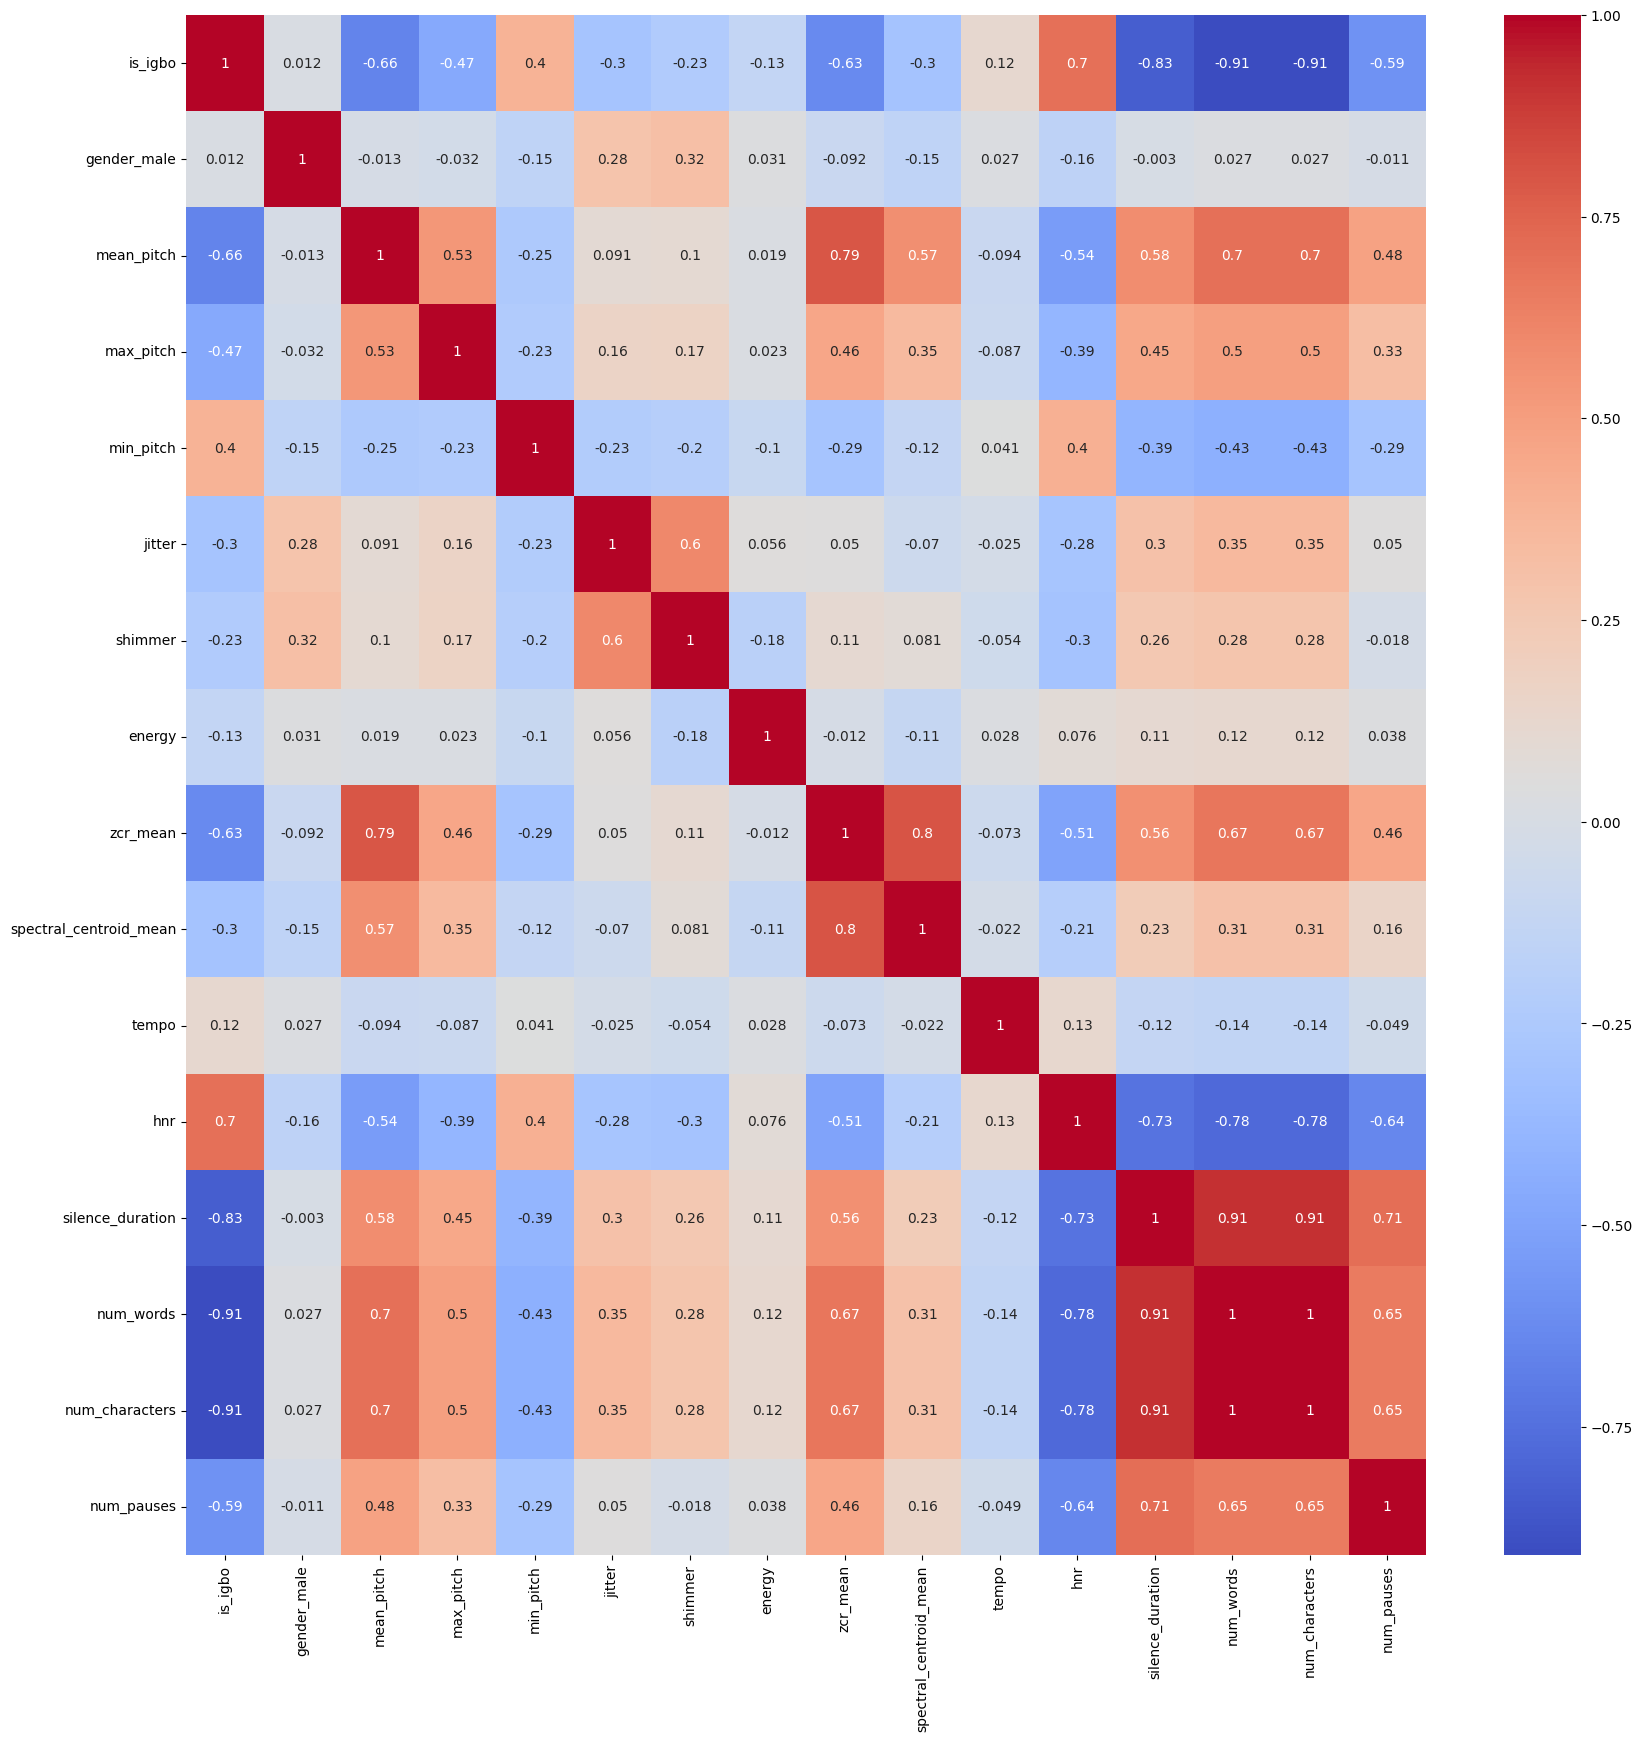

In [26]:
corr = X_train_transformed.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.show()

In [27]:
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train_transformed, y_train)
rmse_1 = root_mean_squared_error(y_true=y_test, y_pred=reg.predict(vanilla_transformation.transform(X_test)))
print(rmse_1)

10.443431001826855


In [28]:
sorted(zip(X_train_transformed.columns, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('silence_duration', 0.3252578734524007),
 ('jitter', 0.07256336996861892),
 ('spectral_centroid_mean', 0.06383096550809844),
 ('zcr_mean', 0.0619107023425054),
 ('shimmer', 0.06168526692943519),
 ('max_pitch', 0.06047639748992454),
 ('min_pitch', 0.05983057251001696),
 ('hnr', 0.05970499207242324),
 ('mean_pitch', 0.05899234185648698),
 ('num_pauses', 0.05891589565751415),
 ('energy', 0.057496181182417366),
 ('tempo', 0.044927604890730354),
 ('gender_male', 0.010659480523184302),
 ('num_words', 0.0013363377081649155),
 ('num_characters', 0.001237054055479173),
 ('is_igbo', 0.0011749638525994012)]

### utils non vanilla

In [29]:
def feature_importance_analysis(path, pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(100, random_state=42)), verbose=True, top_n = 10):
    df = pd.read_csv(path, index_col='Id')
    df.drop(columns=["file_name"], inplace=True)
    y = df_dev['target']
    X_train, X_test, y_train, y_test = train_test_split(df, y, shuffle=True, random_state=42)
    pipeline.fit(X_train, y_train)
    predict = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_true=y_test, y_pred=predict)

    feat_importance = sorted(zip(df.columns, pipeline[-1].feature_importances_), key=lambda x: x[1], reverse=True)
    most_important = list()
    
    if verbose:
        print(f"RMSE: {rmse}\n")
        print(f"{f'Worst {-top_n}' if top_n <= 0 else f'Top {top_n}'} Features:\n")

    if top_n > 0:        
        for col in feat_importance[:top_n]:
            if verbose:
                print(col)
            most_important.append(col[0])
    else:        
        for col in feat_importance[top_n:]:
            if verbose:
                print(col)
            most_important.append(col[0])
    
    return most_important

def correlation_plot(path, figsize=(20,20), annot=False):
    data = pd.read_csv(path)
    data.drop(columns=["file_name", "Id"], inplace=True)
    columns = data.columns

    ss_data = pd.DataFrame(StandardScaler().fit_transform(data), columns=columns)
    corr = ss_data.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr, cmap="coolwarm", annot=annot)
    plt.show()

def evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred, root_mean_squared_error(y_test, y_pred), model

### **Spectral Data**

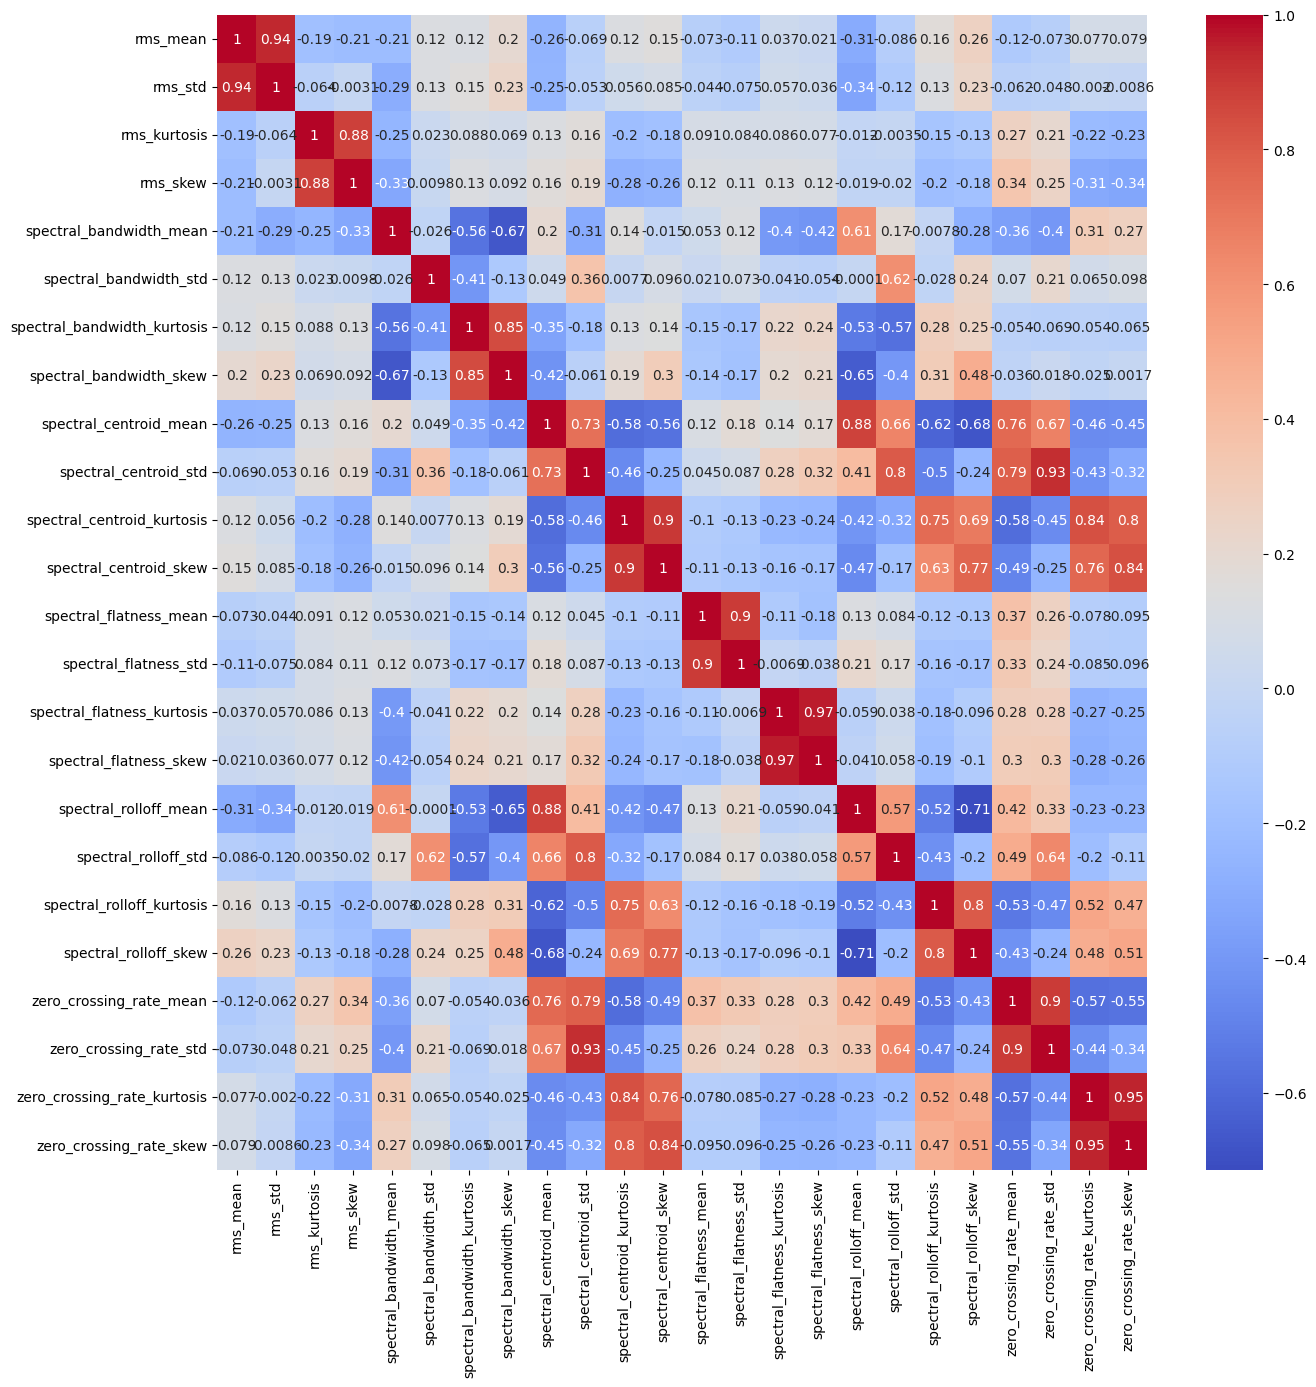

In [30]:
correlation_plot("data/dev_spectral_audio_features.csv", figsize=(15,15), annot=True)

In [31]:
_ = feature_importance_analysis(path="data/dev_spectral_audio_features.csv")

RMSE: 11.02424522430754

Top 10 Features:

('spectral_bandwidth_mean', 0.25062078522514225)
('spectral_bandwidth_skew', 0.047116867020311155)
('spectral_flatness_mean', 0.044090946112197084)
('spectral_flatness_std', 0.04293068954516789)
('spectral_flatness_kurtosis', 0.041307090881977926)
('rms_std', 0.04115014648916498)
('rms_kurtosis', 0.03845815852566933)
('zero_crossing_rate_mean', 0.03765037531152295)
('spectral_bandwidth_kurtosis', 0.03709267747163449)
('rms_mean', 0.03447549390211646)


### **Spectral Contrast**

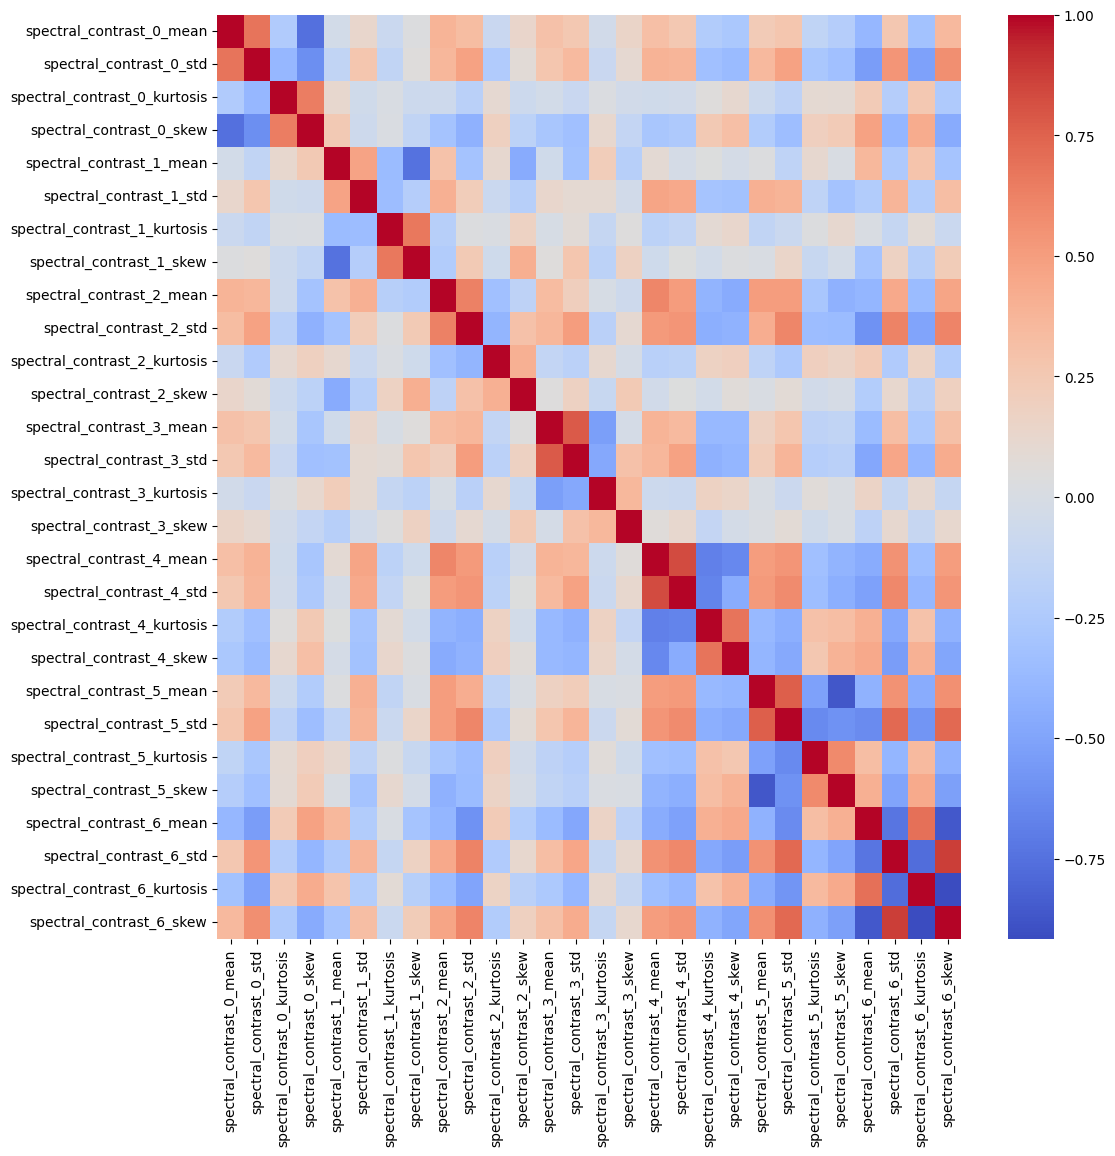

In [32]:
correlation_plot("data/dev_spectral_contrast_audio_features.csv", figsize=(12, 12))

In [33]:
_ = feature_importance_analysis("data/dev_spectral_contrast_audio_features.csv")

RMSE: 10.668676459196247

Top 10 Features:

('spectral_contrast_6_kurtosis', 0.1938163521620416)
('spectral_contrast_0_std', 0.0635082744984317)
('spectral_contrast_0_skew', 0.05157007601561084)
('spectral_contrast_6_std', 0.04626893019747696)
('spectral_contrast_3_std', 0.039600055415635015)
('spectral_contrast_5_std', 0.037976513686374114)
('spectral_contrast_3_mean', 0.034909710024822495)
('spectral_contrast_4_std', 0.032402243512786845)
('spectral_contrast_4_kurtosis', 0.03186656062131542)
('spectral_contrast_4_mean', 0.030736574557020595)


### **Melspectrogram Data**

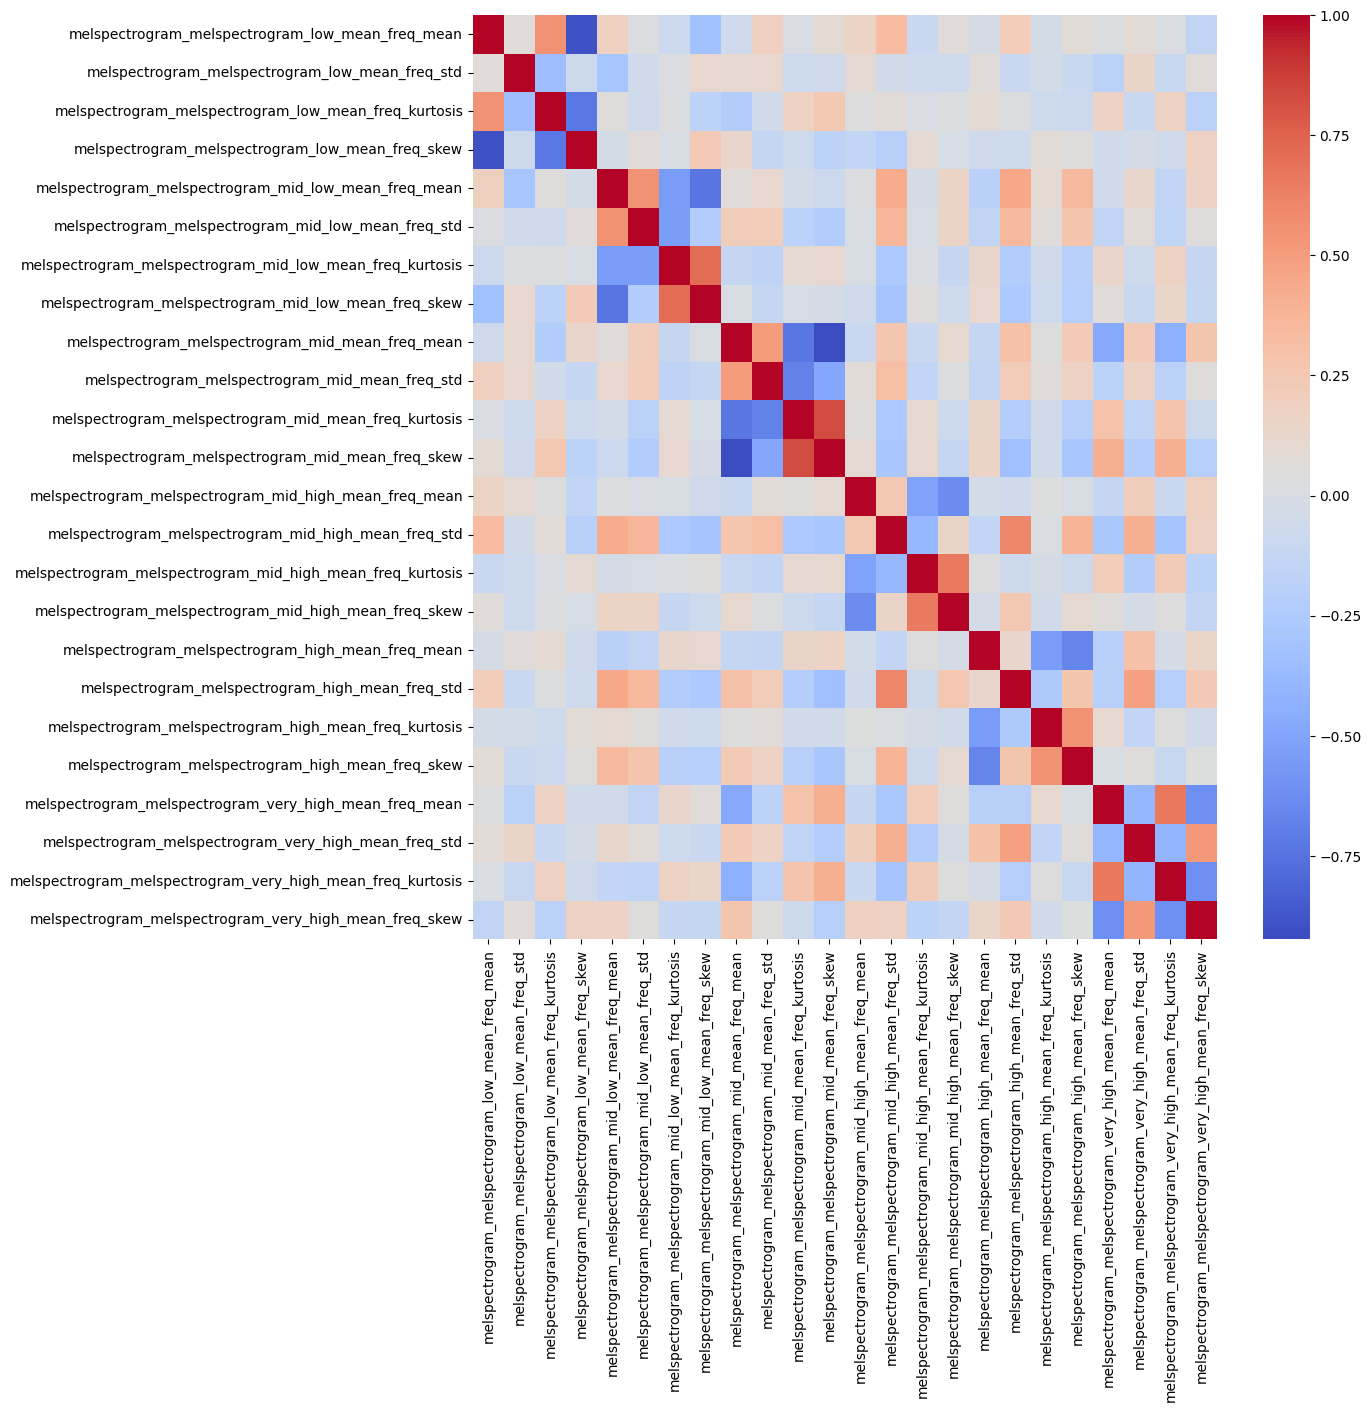

In [34]:
correlation_plot("data/dev_melspectrogram_audio_features.csv", figsize=(12, 12))

In [35]:
_ = feature_importance_analysis(path="data/dev_melspectrogram_audio_features.csv")

RMSE: 10.829334797955621

Top 10 Features:

('melspectrogram_melspectrogram_high_mean_freq_std', 0.13222760834444686)
('melspectrogram_melspectrogram_high_mean_freq_mean', 0.12544916614157614)
('melspectrogram_melspectrogram_mid_low_mean_freq_mean', 0.07356616710354198)
('melspectrogram_melspectrogram_mid_mean_freq_std', 0.06597695166214042)
('melspectrogram_melspectrogram_mid_high_mean_freq_std', 0.03791521451396183)
('melspectrogram_melspectrogram_low_mean_freq_std', 0.035205406645476264)
('melspectrogram_melspectrogram_very_high_mean_freq_mean', 0.0341422417226384)
('melspectrogram_melspectrogram_mid_low_mean_freq_std', 0.03409626474651129)
('melspectrogram_melspectrogram_very_high_mean_freq_std', 0.03332977280220206)
('melspectrogram_melspectrogram_mid_low_mean_freq_kurtosis', 0.033314674998387694)


### **Fundamental frequency**

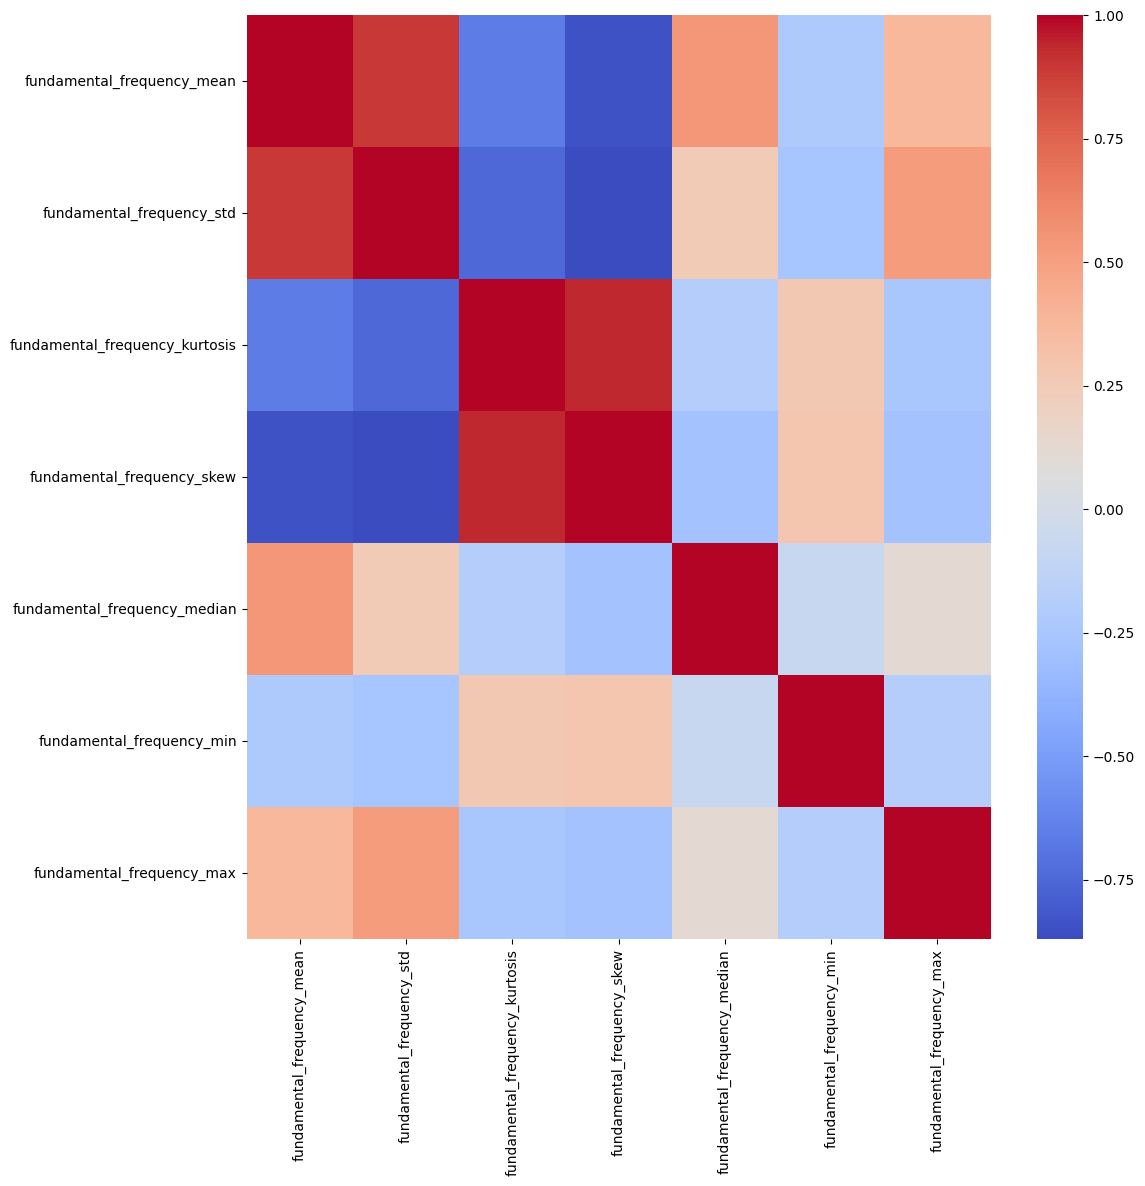

In [36]:
correlation_plot("data/dev_fundamental_frequency_audio_features.csv", figsize=(12, 12))

In [37]:
_ = feature_importance_analysis(path="data/dev_fundamental_frequency_audio_features.csv")

RMSE: 11.560255362799452

Top 10 Features:

('fundamental_frequency_mean', 0.26221296445321335)
('fundamental_frequency_median', 0.18587748787359687)
('fundamental_frequency_std', 0.15995624531127178)
('fundamental_frequency_skew', 0.12203985186338852)
('fundamental_frequency_kurtosis', 0.11564200045241375)
('fundamental_frequency_min', 0.07897929583461909)
('fundamental_frequency_max', 0.0752921542114966)


### **MFCCs & Deltas**

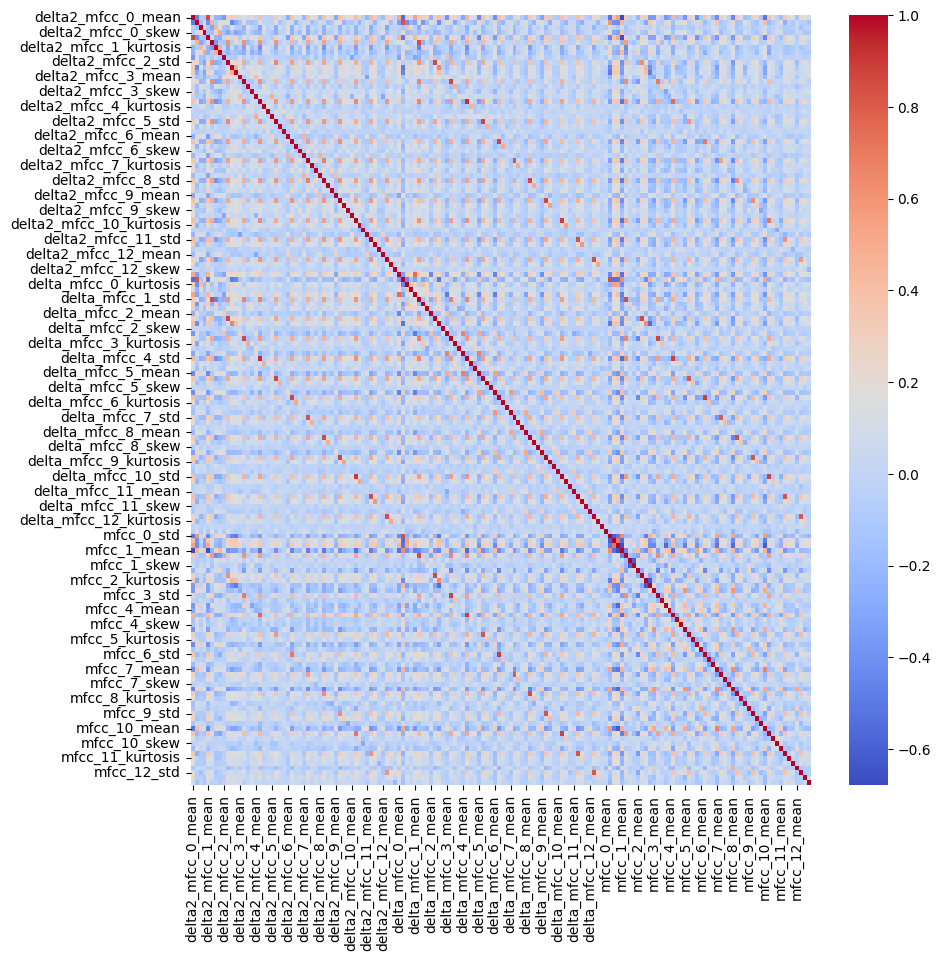

In [226]:
correlation_plot("data/dev_mfcc_deltas_audio_features.csv", figsize=(10,10))

In [227]:
_ = feature_importance_analysis("data/dev_mfcc_deltas_audio_features.csv", top_n=-10)

RMSE: 10.191123637152991

Worst 10 Features:

('delta2_mfcc_11_std', 0.0026289788920267673)
('delta_mfcc_12_mean', 0.002605713029254203)
('mfcc_11_skew', 0.002582618128102535)
('delta_mfcc_3_std', 0.0025641520781072543)
('delta_mfcc_7_mean', 0.002562008161536237)
('delta2_mfcc_5_mean', 0.0025359670140220054)
('mfcc_1_kurtosis', 0.0024540632491886734)
('delta_mfcc_6_std', 0.002453310830511099)
('delta_mfcc_2_std', 0.002312914335916029)
('delta2_mfcc_8_mean', 0.002132094161941213)


# Model Selection

In [38]:
def evaluate_model(X_train, y_train, X_test, y_test, model):   
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred, root_mean_squared_error(y_test, y_pred), model


def list_duplicates(seq):
  seen = set()
  seen_add = seen.add
  # adds all elements it doesn't know yet to seen and all other to seen_twice
  seen_twice = set( x for x in seq if x in seen or seen_add(x) )
  # turn the set into a list (as requested)
  return list( seen_twice )


def compute_rmse_different_dataframe(df_dev, df_dev_extracted_from_audio, model, EXTRACTED_COLS, verbose = False, drop=False):
    
    GIVEN_DATA_COLS = df_dev.columns
    # DROP POSSIBLE ALREADY EXTRACTED DATA
    
    if drop:
        df_dev_full = pd.concat([df_dev, df_dev_extracted_from_audio.drop(columns=EXTRACTED_COLS)], axis=1)
        EXTRACTED_COLS = [col for col in df_dev_extracted_from_audio.columns.to_list() if col not in EXTRACTED_COLS]
    else:
        EXTRACTED_COLS = [col for col in EXTRACTED_COLS if col not in GIVEN_DATA_COLS]
        df_dev_full = pd.concat([df_dev, df_dev_extracted_from_audio[EXTRACTED_COLS]], axis=1)
    
    X, y = df_dev_full.drop(columns=["target"]), df_dev_full["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    final_transformation = ColumnTransformer(
    transformers=[
            ("is_igbo", EthnicityBinarization(), ["ethnicity"]),
            ("ohe_gender", OneHotEncoder(categories="auto", drop="first", handle_unknown="ignore"), ["gender"]),
            ("ss_scaler", StandardScaler(), ["mean_pitch", "max_pitch", "min_pitch",
                                            "jitter", "shimmer", "energy", "zcr_mean", 
                                            "spectral_centroid_mean","tempo","hnr", "silence_duration"]),
            ("mm_scaler", MinMaxScaler(), ["num_words", "num_characters", "num_pauses"]),
            ("ss_scaler_audio", StandardScaler(), EXTRACTED_COLS)
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
        sparse_threshold=0
    )
    pipeline = make_pipeline(
        final_transformation,
        # TruncatedSVD(n_components=40, random_state=42),  
        model 
    )
    
    _, rmse, pipeline = evaluate_model(X_train, y_train, X_test, y_test, pipeline)
    if verbose:
        display(sorted(zip(X.columns, pipeline[-1].feature_importances_), key=lambda x: x[1], reverse=True))
    return rmse

## Evaluating possible best features

In [39]:
df_dev_melspectrogram = (pd.read_csv("data/dev_melspectrogram_audio_features.csv", index_col='Id').drop(columns=["file_name"]))
df_eval_melspectrogram = (pd.read_csv("data/eval_melspectrogram_audio_features.csv", index_col='Id').drop(columns=["file_name"]))

df_dev_mffc_deltas = (pd.read_csv("data/dev_mfcc_deltas_audio_features.csv", index_col='Id').drop(columns=["file_name"]))
df_eval_mffc_deltas = (pd.read_csv("data/eval_mfcc_deltas_audio_features.csv", index_col='Id').drop(columns=["file_name"]))

df_dev_spectral = (pd.read_csv("data/dev_spectral_audio_features.csv", index_col='Id').drop(columns=["file_name"]))
df_eval_spectral = (pd.read_csv("data/eval_spectral_audio_features.csv", index_col='Id').drop(columns=["file_name"]))

df_dev_contrast = (pd.read_csv("data/dev_spectral_contrast_audio_features.csv", index_col='Id').drop(columns=["file_name"]))
df_eval_contrast = (pd.read_csv("data/eval_spectral_contrast_audio_features.csv", index_col='Id').drop(columns=["file_name"]))

df_dev_fundamental_frequency = (pd.read_csv("data/dev_fundamental_frequency_audio_features.csv", index_col='Id').drop(columns=["file_name"]))
df_eval_fundamental_frequency = (pd.read_csv("data/eval_fundamental_frequency_audio_features.csv", index_col='Id').drop(columns=["file_name"]))

GIVEN_DATA_COLS = list(df_dev.columns)
MELSPECTROGRAM_COLS = list(df_dev_melspectrogram.columns)
MFFC_DELTAS_COLS = list(df_dev_mffc_deltas.columns)
SPECTRAL_COLS = list(df_dev_spectral.columns)
CONTRAST_COLS = list(df_dev_contrast.columns)
FUNDAMENTAL_FREQUENCY_COLS = list(df_dev_fundamental_frequency.columns)

df_dev_extracted_from_audio = pd.concat([df_dev_melspectrogram, df_dev_mffc_deltas, df_dev_spectral, df_dev_contrast, df_dev_fundamental_frequency], axis=1)
df_eval_extracted_from_audio = pd.concat([df_eval_melspectrogram, df_eval_mffc_deltas, df_eval_spectral, df_eval_contrast, df_eval_fundamental_frequency], axis=1)

### All the features together

In [40]:
EXTRACTED_COLS = GIVEN_DATA_COLS + MELSPECTROGRAM_COLS + MFFC_DELTAS_COLS + SPECTRAL_COLS + CONTRAST_COLS + FUNDAMENTAL_FREQUENCY_COLS

rmse = compute_rmse_different_dataframe(df_dev, df_dev_extracted_from_audio, 
                                        RandomForestRegressor(random_state=42), EXTRACTED_COLS)
print(rmse)

9.605382256328518


### Taking the first 10 variables per df

In [41]:
main_cols = list()
paths = ['data/dev_melspectrogram_audio_features.csv', 'data/dev_mfcc_deltas_audio_features.csv',  'data/dev_spectral_audio_features.csv', 'data/dev_spectral_contrast_audio_features.csv', 'data/dev_fundamental_frequency_audio_features.csv']

for path in paths:
    main_cols.append(feature_importance_analysis(path, verbose=False))

In [42]:
EXTRACTED_COLS = [feature for top_ten in main_cols for feature in top_ten]

rmse = compute_rmse_different_dataframe(df_dev, df_dev_extracted_from_audio, 
                                        RandomForestRegressor(random_state=42), EXTRACTED_COLS, verbose=False)
print(rmse)

9.626061123785552


In [43]:
final_transformation = ColumnTransformer(
    transformers=[
            ("is_igbo", EthnicityBinarization(), ["ethnicity"]),
            ("ohe_gender", OneHotEncoder(categories="auto", drop="first", handle_unknown="ignore"), ["gender"]),
            ("ss_scaler", StandardScaler(), ["mean_pitch", "max_pitch", "min_pitch",
                                            "jitter", "shimmer", "energy", "zcr_mean", 
                                            "spectral_centroid_mean","tempo","hnr", "silence_duration"]),
            ("mm_scaler", MinMaxScaler(), ["num_words", "num_characters", "num_pauses"]),
            ("ss_scaler_audio", StandardScaler(), EXTRACTED_COLS)
        ],
        remainder="drop",
        verbose_feature_names_out=False,
        sparse_threshold=0
    )

pipeline = make_pipeline(
    final_transformation, 
    RandomForestRegressor() 
)

df_dev_full = pd.concat([df_dev, df_dev_extracted_from_audio[EXTRACTED_COLS]], axis=1)
df_eval_full = pd.concat([df_eval, df_eval_extracted_from_audio[EXTRACTED_COLS]], axis=1)

X, y = df_dev_full.drop(columns=["target"]), df_dev_full["target"]
X.shape, y.shape

pipeline.fit(X, y)
y_pred = pipeline.predict(df_eval_full)

res = pd.DataFrame({'Id': df_eval_full.index, 'Predicted': y_pred})
res.to_csv('submissions/submission.csv', sep=',', index=False)

## Given features, mel and mfcc

In [53]:
EXTRACTED_COLS = MELSPECTROGRAM_COLS + MFFC_DELTAS_COLS

rmse = compute_rmse_different_dataframe(df_dev, df_dev_extracted_from_audio, 
                                        RandomForestRegressor(random_state=42), EXTRACTED_COLS, verbose=False)
print(rmse)

9.731977967684047


## Removing worst 20

In [54]:
main_cols = list()
paths = ['data/dev_melspectrogram_audio_features.csv', 'data/dev_mfcc_deltas_audio_features.csv',  'data/dev_spectral_audio_features.csv', 'data/dev_spectral_contrast_audio_features.csv']

for path in paths:
    main_cols.append(feature_importance_analysis(path, verbose=False, top_n=-20))

In [55]:
EXTRACTED_COLS = [feature for worst_twenty in main_cols for feature in worst_twenty]

rmse = compute_rmse_different_dataframe(df_dev, df_dev_extracted_from_audio, 
                                        RandomForestRegressor(random_state=42), EXTRACTED_COLS, verbose=False, drop = True)
print(rmse)

9.618814189393708


# ----------------------------------------  FINE ----------------------------------------

# Evaluating possible best model

In [44]:
def compute_rmse_different_models(df_dev, df_dev_extracted_from_audio, EXTRACTED_COLS, drop=False):
    random_state = 42
    t = PrettyTable()
    t.field_names = ['model', 'RMSE']

    models = [
        LinearRegression(),
        Lasso(random_state=random_state),
        Ridge(random_state=random_state),
        MLPRegressor(hidden_layer_sizes=(10,), random_state=random_state, max_iter=10000),
        MLPRegressor(hidden_layer_sizes=(10,10),  activation='tanh', solver='lbfgs',
                    alpha=0.000, batch_size='auto', learning_rate='constant',
                    learning_rate_init=0.01, power_t=0.5, max_iter=10000, shuffle=True,
                    random_state=random_state, tol=0.0001, verbose=True, warm_start=False,
                    momentum=0.0, nesterovs_momentum=False, early_stopping=False,
                    validation_fraction=0.0, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
        SVR(gamma='scale'),
        RandomForestRegressor(n_estimators=100, random_state=random_state),
        GradientBoostingRegressor(random_state=random_state),
        CatBoostRegressor(random_seed=random_state, logging_level="Silent"),
    ]

    names = [
        'linreg',
        'lasso',
        'ridge',
        'mlp_standard',
        'mlp_tuned',
        'svr',
        'rf',
        'gbr',
        'cbr',
    ]

    GIVEN_DATA_COLS = df_dev
    
    if drop:
        df_dev_full = pd.concat([df_dev, df_dev_extracted_from_audio.drop(columns=EXTRACTED_COLS)], axis=1)
        EXTRACTED_COLS = [col for col in df_dev_extracted_from_audio.columns.to_list() if col not in EXTRACTED_COLS]
    else:
        # DROP POSSIBLE ALREADY EXTRACTED DATA
        EXTRACTED_COLS = [col for col in EXTRACTED_COLS if col not in GIVEN_DATA_COLS]
        df_dev_full = pd.concat([df_dev, df_dev_extracted_from_audio[EXTRACTED_COLS]], axis=1)

    X, y = df_dev_full.drop(columns=["target"]), df_dev_full["target"]
    final_transformation = ColumnTransformer(
        transformers=[
                ("is_igbo", EthnicityBinarization(), ["ethnicity"]),
                ("ohe_gender", OneHotEncoder(categories="auto", drop="first", handle_unknown="ignore"), ["gender"]),
                ("ss_scaler", StandardScaler(), ["mean_pitch", "max_pitch", "min_pitch",
                                                "jitter", "shimmer", "energy", "zcr_mean", 
                                                "spectral_centroid_mean","tempo","hnr", "silence_duration"]),
                ("mm_scaler", MinMaxScaler(), ["num_words", "num_characters", "num_pauses"]),
                ("ss_scaler_audio", StandardScaler(), EXTRACTED_COLS)
            ],
            remainder="drop",
            verbose_feature_names_out=False,
            sparse_threshold=0
    )

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y.astype(int), test_size=0.25, random_state=42)

    for model, name in zip(models, names):
        model_pipeline = IMBPipeline(
            [
                ("transformation", final_transformation),
                ("sampler", RandomOverSampler(sampling_strategy="minority")),
                ("dim_reduction", LinearDiscriminantAnalysis()),
                ("classifier", model)
            ]
        )
        _, rmse, _ = evaluate_model(X_train, y_train, X_test, y_test, model_pipeline)
        t.add_row([name, rmse])

    print(t)

### All dataset

In [45]:
EXTRACTED_COLS = GIVEN_DATA_COLS + MELSPECTROGRAM_COLS + MFFC_DELTAS_COLS + SPECTRAL_COLS + CONTRAST_COLS + FUNDAMENTAL_FREQUENCY_COLS

compute_rmse_different_models(df_dev, df_dev_extracted_from_audio, EXTRACTED_COLS)

+--------------+--------------------+
|    model     |        RMSE        |
+--------------+--------------------+
|    linreg    | 9.910894271946093  |
|    lasso     | 9.931390286376798  |
|    ridge     | 9.910639122436397  |
| mlp_standard | 11.27474990718148  |
|  mlp_tuned   | 15.783121016867117 |
|     svr      | 10.838990231836632 |
|      rf      | 9.507554625618937  |
|     gbr      | 9.382859146941428  |
|     cbr      | 9.088392009477472  |
+--------------+--------------------+


## Taking the first 10 variables per df

In [102]:
main_cols = list()
paths = ['data/dev_melspectrogram_audio_features.csv', 'data/dev_mfcc_deltas_audio_features.csv', 'data/dev_spectral_audio_features.csv', 'data/dev_spectral_contrast_audio_features.csv']

for path in paths:
    main_cols.append(feature_importance_analysis(path, verbose=False))

In [103]:
EXTRACTED_COLS = [feature for top_ten in main_cols for feature in top_ten]

compute_rmse_different_models(df_dev, df_dev_extracted_from_audio, EXTRACTED_COLS)

+--------------+--------------------+
|    model     |        RMSE        |
+--------------+--------------------+
|    linreg    | 10.382205049016232 |
|    lasso     | 10.465215173719894 |
|    ridge     | 10.382135102466856 |
| mlp_standard | 10.704320650433356 |
|  mlp_tuned   | 13.70383123044768  |
|     svr      | 10.90534588190566  |
|      rf      | 9.626303415054613  |
|     gbr      | 9.548141377767056  |
|     cbr      | 9.258199846231692  |
+--------------+--------------------+


## Removing worst 20

In [60]:
main_cols = list()
paths = ['data/dev_melspectrogram_audio_features.csv', 'data/dev_mfcc_deltas_audio_features.csv',  'data/dev_spectral_audio_features.csv', 'data/dev_spectral_contrast_audio_features.csv']

for path in paths:
    main_cols.append(feature_importance_analysis(path, verbose=False, top_n=-20))
EXTRACTED_COLS = [feature for worst_twenty in main_cols for feature in worst_twenty]

rmse = compute_rmse_different_models(df_dev, df_dev_extracted_from_audio, EXTRACTED_COLS, drop=False)
print(rmse)

c:\Users\andre\Documents\University\1st Year\Data Science Lab process and methods (2024-25)\final_project\DSL-Age-Estimation\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\andre\Documents\University\1st Year\Data Science Lab process and methods (2024-25)\final_project\DSL-Age-Estimation\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


+--------------+--------------------+
|    model     |        RMSE        |
+--------------+--------------------+
|    linreg    | 9.948694827189767  |
|    lasso     | 10.554120466497297 |
|    ridge     |  9.94437550840299  |
| mlp_standard | 10.970791662626995 |
|  mlp_tuned   | 12.950686351680728 |
|     svr      | 10.769168784968612 |
|      rf      |  9.94127591023573  |
|     gbr      | 9.718972392795003  |
|     cbr      | 9.420542673048471  |
|    lgbmr     | 9.738342255064666  |
+--------------+--------------------+
None


c:\Users\andre\Documents\University\1st Year\Data Science Lab process and methods (2024-25)\final_project\DSL-Age-Estimation\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Final tests

In [46]:
AUDIO_DFs = [df_dev_spectral, df_dev_contrast, df_dev_melspectrogram, df_dev_mffc_deltas, df_dev_fundamental_frequency]
AUDIO_COLS = []

for df in AUDIO_DFs:
    columns = list(df.columns)
    AUDIO_COLS = AUDIO_COLS + columns

In [47]:
final_transformation = ColumnTransformer(
    transformers=[
            ("is_igbo", EthnicityBinarization(), ["ethnicity"]),
            ("ohe_gender", OneHotEncoder(categories="auto", drop="first", handle_unknown="ignore"), ["gender"]),
            ("ss_scaler", StandardScaler(), ["mean_pitch", "max_pitch", "min_pitch",
                                            "jitter", "shimmer", "energy", "zcr_mean", 
                                            "spectral_centroid_mean","tempo","hnr", "silence_duration"]),
            ("mm_scaler", MinMaxScaler(), ["num_words", "num_characters", "num_pauses"]),
            ("ss_scaler_audio", StandardScaler(), AUDIO_COLS)
        ],
        remainder="drop",
        verbose_feature_names_out=False,
        sparse_threshold=0
    )

In [49]:
df_dev_full = pd.concat([df_dev.drop(columns=["spectral_centroid_mean"]), df_dev_spectral, df_dev_contrast, df_dev_melspectrogram, df_dev_mffc_deltas, df_dev_fundamental_frequency], axis=1)
df_eval_full = pd.concat([df_eval.drop(columns=["spectral_centroid_mean"]), df_eval_spectral, df_eval_contrast, df_eval_melspectrogram, df_eval_mffc_deltas, df_eval_fundamental_frequency], axis=1)

X, y = df_dev_full.drop(columns=["target"]), df_dev["target"].astype(int)

In [57]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
model_pipeline = IMBPipeline(
    [
        ("transformation", final_transformation),
        ("sampler", RandomOverSampler(sampling_strategy="minority")),
        ("dim_reduction", LinearDiscriminantAnalysis()),
        ("classifier", CatBoostRegressor(random_seed=42, logging_level="Silent", iterations=2000))
    ]
)

model_pipeline.fit(X=X_train, y=y_train)
prediction = model_pipeline.predict(X=X_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=prediction)
print("RMSE = ", rmse)

RMSE =  8.749389352789676


## for submit

In [60]:
df_dev_full = pd.concat([df_dev.drop(columns=["spectral_centroid_mean"]), df_dev_spectral, df_dev_contrast, df_dev_melspectrogram, df_dev_mffc_deltas, df_dev_fundamental_frequency], axis=1)
df_eval_full = pd.concat([df_eval.drop(columns=["spectral_centroid_mean"]), df_eval_spectral, df_eval_contrast, df_eval_melspectrogram, df_eval_mffc_deltas, df_eval_fundamental_frequency], axis=1)

X_train, y = df_dev_full.drop(columns=["target"]), df_dev["target"].astype(int)

model_pipeline = IMBPipeline(
    [
        ("transformation", final_transformation),
        ("sampler", RandomOverSampler(sampling_strategy="minority")),
        ("dim_reduction", LinearDiscriminantAnalysis()),
        ("classifier", CatBoostRegressor(random_seed=42, logging_level="Silent", iterations=2000))
    ]
)

model_pipeline.fit(X=X_train, y=y)
prediction = model_pipeline.predict(X=df_eval_full)

pd.DataFrame({'Id': df_eval_full.index, 'Predicted': prediction}).to_csv('submissions/submission_final.csv', sep=',', index=False)

In [241]:
sampler_configs = [
    {
        'sampler': [None]
    },
    {
        'sampler': [RandomOverSampler(random_state=42)],
        'sampler__sampling_strategy': ['minority', 'not minority', 'all', 'auto']
    },
    {
        'sampler': [RandomUnderSampler(random_state=42)],
        'sampler__sampling_strategy': ['majority', 'not majority', 'all', 'auto']
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA(random_state=42)],
        'dim_reduction__n_components': [0.8, 0.9, 0.95, 0.99]
    },
    {
        'dim_reduction': [LinearDiscriminantAnalysis()],
        'dim_reduction__solver': ['svd', 'eigen']
    }
]

classifier_configs = [
    {
        'classifier': [RandomForestRegressor(n_jobs=-1, random_state=42)],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 3, 4, 5],
        'classifier__max_features': ['sqrt', 'log2', None]
    },
    {
        'classifier': [GradientBoostingRegressor(random_state=42)],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.001, 0.01, 0.1],
        'classifier__max_depth': [None, 3, 4, 5],
        'classifier__max_features': ['sqrt', 'log2', None]
    },
    {
        'classifier': [CatBoostRegressor(random_seed=42, loss_function="RMSE", logging_level="Silent")],
        'classifier__iterations': [500, 1000, 2000],
        'classifier__learning_rate': [0.001, 0.01, 0.03, 0.1],
        'classifier__depth': [6, 7, 8]
    }
]


In [242]:
all_configs = []
for configuration in itertools.product(sampler_configs, dim_reduction_configs, classifier_configs):
    all_configs.append((dict(itertools.chain(*(e.items() for e in configuration)))))
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 27'

In [243]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

In [ ]:
scores = cross_validate(rs, X_train, y_train, scoring='neg_root_mean_squared_error', cv = 5, return_estimator=True, verbose=3) 

In [45]:
print('#'*100)
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('- '*100)

####################################################################################################
None
RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
-10.137639379108485
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
None
GradientBoostingRegressor(random_state=42) {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 

In [46]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    rmse_train = root_mean_squared_error(y_train, pred_train)
    rmse_test = root_mean_squared_error(y_test, pred_test)
    print(f'RMSE on training set:{rmse_train}, RMSE on test set:{rmse_test}')

RMSE on training set:3.960763415349906, RMSE on test set:9.550878537325923
RMSE on training set:7.389966259192815, RMSE on test set:9.390861814680383
RMSE on training set:4.353103658812687, RMSE on test set:9.49156741609539
RMSE on training set:9.214431287051504, RMSE on test set:9.94315114479936
RMSE on training set:7.389966259192815, RMSE on test set:9.390861814680383


In [47]:
predictions = list()
for estimator in scores['estimator']:
    estimator.best_estimator_.fit(X, y)
    predictions.append(estimator.best_estimator_.predict(df_eval))

[array([38.45  , 40.    , 22.97  , 34.2475, 36.145 , 25.785 , 25.955 ,
        19.75  , 34.07  , 22.47  , 46.9825, 19.985 , 38.525 , 20.03  ,
        38.145 , 30.74  , 41.87  , 32.53  , 28.505 , 24.735 , 33.2725,
        40.5675, 48.2   , 31.21  , 35.6   , 34.8   , 25.6075, 21.865 ,
        32.4225, 27.395 , 27.53  , 40.145 , 25.92  , 19.515 , 39.16  ,
        21.13  , 21.4   , 36.3625, 19.67  , 24.87  , 21.06  , 24.665 ,
        39.2625, 38.22  , 48.69  , 36.285 , 41.125 , 32.275 , 22.5   ,
        32.02  , 38.415 , 24.45  , 33.41  , 25.84  , 32.96  , 29.875 ,
        29.5575, 33.465 , 29.88  , 27.125 , 21.16  , 21.67  , 35.39  ,
        20.805 , 28.545 , 32.4875, 18.15  , 23.31  , 23.78  , 36.73  ,
        24.295 , 19.015 , 32.155 , 23.74  , 36.565 , 43.045 , 35.17  ,
        28.145 , 19.77  , 26.1175, 22.6   , 31.6   , 37.25  , 31.45  ,
        20.085 , 45.315 , 20.25  , 26.77  , 23.735 , 20.795 , 38.005 ,
        19.32  , 18.62  , 35.215 , 19.1   , 19.44  , 23.415 , 39.0125,
      

In [48]:
ids = df_eval.index

for i, pred in enumerate(predictions):
    res = pd.DataFrame({'Id': ids, 'Predicted': pred})
    res.to_csv(f'submissions/submission_{i}.csv', sep=',', index=False)

## Results